# FINM 33150 Homework 3 Quantile Trading 
### Huayu Zhu (huayuz) - UCID: 12413518
### Date: Jan 28th, 2024 

## 1.Introduction 

### 1.1 Motivation 

In this notebook, I will use the data from ZACKS to conduct a quantile trading strategy and test the impact of changes on parameters. 

Tickers selected: 243

Trading dates: start = 2016-01-01, end = '2023-07-31

Ratios used for signals: Debt Market cap ratio, Price to Earnings Ratio, Return on Investment Ratio 

The structure of this notebook:
1. I will firstly try to look over the documentation about the database and try to filter the tickers using the requirements. 
2. After that, I will implement the calculation function for ratios and double check it with sample ticker. 
3. I will look through the basic properties about ratios and prices we get. 
4. I will implement the tradings strategy and try to change the parameters to see the effect. 

SideNote: In hw 1, it seems like there are some issues with showing the graph drawn by plotly. I double checked and you might need to click trust if you downloading it. Just in case, the graph fails to present, I will also give draw the graph again using other library. I would prefer plotly because it is able to zoom in to check small trend or pattern. 

### 1.2 Packages & Key Constants & Helper Functions

#### Packages 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.stats import norm
import plotly.express as px
import pandas as pd
import numpy as np
import scipy as sp
import quandl
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import coint
from dataclasses import dataclass
from enum import Enum
from statsmodels.regression.rolling import RollingOLS
import warnings
warnings.filterwarnings('ignore')
from IPython.display import Image
from scipy.stats import pearsonr
from plotly.offline import iplot
from sklearn.preprocessing import StandardScaler

#### Key Constants 

In [2]:
myAPIkey = 'yourAPI'
quandl.ApiConfig.api_key = myAPIkey

# Data Filtering 
## Industry Filter 
excluded_industries = [6021,6022,6029,6035,6036,6099,6111,6141,6153,6159,6162,6163,6172,6189,6199,6200,6211,6282,6311,6321,6324,6331,6351,6361,6399,6411,7500]
industry_excluded_check_str = ['Auto/Tires/Trucks','Finance']

## date range 
start = '2016-01-01'
end = '2023-07-31'

## sample test date 
sample_test_date = [
 '2021-10-27',
 '2021-10-28',
 '2021-12-31',
 '2022-01-03',
 '2022-02-23',
 '2022-02-24',
 '2022-03-31',
 '2022-04-01',
 '2022-04-29',
 '2022-05-02',
 '2022-06-30',
 '2022-07-01',
 '2022-08-04',
 '2022-08-05',
 '2022-09-30',
 '2022-10-03',
 '2022-11-01',
 '2022-11-02',
 '2022-12-30',
 '2023-01-03',
 '2023-02-22',
 '2023-02-23',
 '2023-03-31',
 '2023-04-03',
 '2023-04-27',
 '2023-04-28',
 '2023-06-30',
 '2023-07-03'
]



#### Helper Functions 

##### MT table Industry Filtering 

In [3]:
def industry_filter(df):
    # select only active ticker
    df = df[df['active_ticker_flag'] != 'N']
    print('Filter inactive ticker. Left tickers:', df.shape[0])

 
    df['zacks_x_sector_desc'] = df['zacks_x_sector_desc'].fillna('')
    #select companied that are not in automotive, financial, insurance industry 
    mask = df['zacks_x_sector_desc'].str.contains('|'.join(industry_excluded_check_str), case=False)
    df = df[~mask]
    print('Filter based on industry, trail 1. Left tickers:', df.shape[0])

    # double check with filtering 
    df['sic_4_code'] = df['sic_4_code'].fillna('')
    mask2 = df['sic_4_code'].isin(excluded_industries)
    df = df[~mask2]
    print('Filter based on industry, trail 2. Left tickers:', df.shape[0])


    # triple check with filtering 
    #df= df[df['comp_type'] != 7]
    df= df[df['zacks_x_sector_code'] != 13]
    df= df[df['zacks_x_sector_code'] != 5]
    print('Filter based on industry, trail 3. Left tickers:', df.shape[0])

    # filter with Equities
    df = df[df['asset_type'] == 'COM']
    print('Filter based on asset type. Left tickers:', df.shape[0])

    df = df[~df['zacks_x_sector_code'].isna()]

    ticker_list = df['ticker'] 
    return ticker_list 


##### Adj Close Price Filter 

In [4]:
def adj_close_filter_m1(list_ticker, start, end): 
    ticker_list_1 = list()
    for ticker in list_ticker: 
        df = quandl.get_table('QUOTEMEDIA/PRICES', ticker = ticker, date = {'gte':start, 'lte':end})
        df = df.sort_values(by = 'date')
        df.set_index('date', inplace = True)
        if df['adj_close'].isna().any() == False: 
            ticker_list_1.append(ticker)
    print('Filter based on available adj_close_price, method 1. Left tickers:',len(ticker_list_1))
    return ticker_list_1 

In [5]:
def adj_close_filter_m2(list_ticker, start, end, sample_len): 
    ticker_list_1 = list() 
    for ticker in list_ticker: 
        df = quandl.get_table('QUOTEMEDIA/PRICES', ticker = ticker, date = {'gte':start, 'lte':end})
        df = df.sort_values(by = 'date')
        df.set_index('date', inplace = True)
        df = df.loc[:,['adj_close']]
        df = df.dropna() 
        if df.shape[0] >= sample_len: 
            ticker_list_1.append(ticker)
    print('Filter based on available adj_close_price, method 2. Left tickers:',len(ticker_list_1))
    return ticker_list_1 

##### Debt Market Filter 

In [6]:
def debt_market_filter(list): 
    filter_list = []
    for ticker in list: 
        Debt = quandl.get_table('ZACKS/FC',ticker = ticker,qopts={"columns":["per_end_date",'tot_lterm_debt']}, paginate=True)
        Debt = Debt.sort_values(by = 'per_end_date').drop_duplicates('per_end_date', keep='last')

        Debt.set_index('per_end_date',inplace = True)
        Debt = Debt.loc[start:end]

        Market = quandl.get_table('ZACKS/MKTV',ticker = ticker, qopts={"columns":["per_end_date",'mkt_val']}, paginate=True)
        Market = Market.sort_values(by = 'per_end_date').drop_duplicates('per_end_date', keep='last')

        Market.set_index('per_end_date',inplace = True)
        Market = Market.loc[start:end]

        combined = pd.concat([Debt,Market],axis = 1)
        combined['mkt_val'] = combined['mkt_val'].replace(0, pd.NA)

        ratio = combined['tot_lterm_debt'] / combined['mkt_val']
        if (ratio > 0.1).any():
            filter_list.append(ticker)
    print('Filter based on debt/market ratio. Left tickers:', len(filter_list))
    return filter_list

##### Data Range Filter 

In [7]:
def data_range_filter(list_ticker): 
    temp_list = list()
    for ticker in list_ticker: 
        Date = quandl.get_table('ZACKS/FC',ticker = ticker,qopts={"columns":["per_end_date"]}, paginate=True)
        Date = Date.sort_values(by = 'per_end_date').drop_duplicates('per_end_date', keep='last')
        Date.index = Date['per_end_date']
        Date = Date[start:end]
        if str(Date.iloc[-1,0])>= '2022-06-30': 
            temp_list.append(ticker)
    print('Filter based on data range. Left tickers:', len(temp_list))
    return temp_list
 

##### Get adj close price for individual ticker 

In [8]:
def get_adj_close_price(ticker): 
    df = quandl.get_table('QUOTEMEDIA/PRICES', ticker = ticker, date = {'gte':start, 'lte':end})
    df = df.sort_values(by = 'date')
    df.set_index('date', inplace = True)
    df = df.loc[:,['adj_close']]
    return df 

##### Get FC table for individual ticker 

In [9]:
def get_FC_table(ticker):
    df = quandl.get_table('ZACKS/FC',ticker = ticker,per_end_date = {'gte':start,'lte':end})
    # get quarterly data 
    df = df[df['per_type'] == 'Q']
    df = df.loc[:,['per_end_date','filing_date','eps_diluted_net','basic_net_eps','net_lterm_debt','tot_lterm_debt']]
    df = df.sort_values(by ='per_end_date')
    df.set_index('per_end_date', inplace = True)
    df.index.names = ['date']
    return df 

##### Get FR table for individual ticker 

In [10]:
def get_FR_table(ticker):
    df = quandl.get_table('ZACKS/FR',ticker = ticker,per_end_date = {'gte':start,'lte':end})
    # get quarterly data 
    df = df[df['per_type'] == 'Q']
    df = df.loc[:,['per_end_date', 'tot_debt_tot_equity','ret_invst']]
    df = df.sort_values(by ='per_end_date')
    df.set_index('per_end_date', inplace = True)
    df.index.names = ['date']
    return df 

##### Get MKTV table for individual ticker 

In [11]:
def get_MKTV_table(ticker):
    df = quandl.get_table('ZACKS/MKTV',ticker = ticker,per_end_date = {'gte':start,'lte':end})
    # get quarterly data 
    df = df[df['per_type'] == 'Q']
    df = df.loc[:,['per_end_date', 'mkt_val']]
    df = df.sort_values(by ='per_end_date')
    df.set_index('per_end_date', inplace = True)
    df.index.names = ['date']
    return df 

##### Get SHRS table for individual ticker 

In [12]:
def get_SHRS_table(ticker):
    df = quandl.get_table('ZACKS/SHRS',ticker = ticker,per_end_date = {'gte':start,'lte':end})
    # get quarterly data 
    df = df[df['per_type'] == 'Q']
    df = df.loc[:,['per_end_date', 'shares_out']]
    df = df.sort_values(by ='per_end_date')
    df.set_index('per_end_date', inplace = True)
    df.index.names = ['date']
    return df 

##### Combine ZACKS tables for individual tickers 

In [13]:
def ZACKS_table_combine(ticker):
    FC = get_FC_table(ticker)
    FR = get_FR_table(ticker)
    MKTV = get_MKTV_table(ticker)
    SHRS = get_SHRS_table(ticker)

    a = list() 
    a.append(FC)
    a.append(FR)
    a.append(MKTV)
    a.append(SHRS)

    df = pd.concat(a, axis = 1)
    return df 

##### Debt to market cap

In [14]:
def debt_to_market_cap(ticker):
    df_price = get_adj_close_price(ticker)
    df_zacks = ZACKS_table_combine(ticker)

    # since zacks table has less data compared with price table, construct quarter close price 
    df = df_zacks.join(df_price)
    df['per_end_date'] = df.index 

    df.index = df['filing_date']
    df = df.loc[:,['adj_close','tot_debt_tot_equity']]
    df.rename(columns={'adj_close':'adj_close_quarter'},inplace= True)

    df_temp = df_price.join(df)

    df_temp['adj_close_quarter'] = df_temp['adj_close_quarter'].shift(1).fillna(method = 'ffill')
    df_temp['tot_debt_tot_equity'] = df_temp['tot_debt_tot_equity'].shift(1).fillna(method = 'ffill')

    df_temp['debt_to_market_cap'] = df_temp['tot_debt_tot_equity'] * df_temp['adj_close_quarter']/df_temp['adj_close']

    return df_temp.loc[:,['debt_to_market_cap']]
    

##### Return on Investment 

In [15]:
def return_on_investment(ticker):
    df_price = get_adj_close_price(ticker)
    df_zacks = ZACKS_table_combine(ticker)

    df_zacks['net_lterm_debt'] = df_zacks['net_lterm_debt'].fillna(df_zacks['tot_lterm_debt'])
    df_zacks['return'] = df_zacks['ret_invst']*(df_zacks['net_lterm_debt']+df_zacks['mkt_val'])

    df = df_zacks[['filing_date','mkt_val','net_lterm_debt','return']]
    df['per_end_date'] = df.index
    df = df.join(df_price)   
    df.index = df['filing_date']
    df.rename(columns={'adj_close':'adj_close_quarter'},inplace= True)

    df_temp = df_price.join(df)

    df_temp['mkt_val'] = df_temp['mkt_val'].shift(1).fillna(method='ffill')
    df_temp['adj_close_quarter'] =  df_temp['adj_close_quarter'].shift(1).fillna(method='ffill')
    df_temp['net_lterm_debt'] =  df_temp['net_lterm_debt'].shift(1).fillna(method='ffill')
    df_temp['return'] =  df_temp['return'].shift(1).fillna(method='ffill')

    df_temp['M'] = df_temp['mkt_val']* df_temp['adj_close'] /df_temp['adj_close_quarter']
    # V = R /(D+M)
    df_temp['return_on_investment'] = df_temp['return']/(df_temp['net_lterm_debt']+df_temp['M'])

    return df_temp.loc[:,['return_on_investment']]

##### Price to earnings 

In [16]:
def price_to_earnings(ticker): 
    df_price = get_adj_close_price(ticker)
    df_zacks = ZACKS_table_combine(ticker)

    df_zacks['eps_diluted_net'] = df_zacks['eps_diluted_net'].fillna(df_zacks['basic_net_eps'])
    df_zacks['eps_diluted_net'] = df_zacks['eps_diluted_net'].apply(lambda x: 0.001 if x < 0 else x)
    df_zacks['per_end_date'] = df_zacks.index 

    df = df_zacks[['per_end_date','filing_date','eps_diluted_net']]  
    df.index = df['filing_date']

    df_temp = df_price.join(df)

    df_temp['eps_diluted_net'] = df_temp['eps_diluted_net'].shift(1).fillna(method='ffill')
    df_temp['price_to_earnings'] = df_temp['adj_close']/df_temp['eps_diluted_net']

    return df_temp.loc[:,['price_to_earnings']]

##### Combine Three Ratios 

In [17]:
def combine_ratios(ticker):
    r1 = debt_to_market_cap(ticker)
    r2 = return_on_investment(ticker)
    r3 = price_to_earnings(ticker)
    r4 = get_adj_close_price(ticker)
    r4 = r4.join(r1, how = 'outer')
    r4['adj_close'] = r4['adj_close'].fillna(method = 'ffill')

    a = list() 
    a.append(r4)
    a.append(r2)
    a.append(r3)

    df = pd.concat(a, axis = 1)

    return df 

##### Fill NaN Value 

In [18]:
def fill_nan(df): 
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.apply(lambda x: x.fillna(x.mean()),axis=0)  
    return df 

##### Summary Statistics 

In [19]:
def summary_statistics(data):
    summary_stats = pd.DataFrame()
    summary_stats['Mean'] = round(data.mean(),3)
    summary_stats['Standard deviation'] = round(data.std(),3)
    
    summary_stats['VaR (0.05)'] = round(data.quantile(0.05),3)
    summary_stats['Quantile 0.25'] = round(data.quantile(0.25),3)
    summary_stats['Median'] = round(data.median(),3)
    summary_stats['Quantile 0.75'] = round(data.quantile(0.75),3)
    
    summary_stats['Skewness'] = round(data.skew(),3)
    summary_stats['Excess Kurtosis'] = round(data.kurtosis(),3)

    summary_stats['Min'] = round(data.min(),3)
    summary_stats['Max'] = round(data.max(),3)
    return summary_stats

##### Summary Statistics Table 

In [20]:
def summary_stats_table(df):
    temp = list() 
    for column in df.columns: 
        data = summary_statistics(df.loc[:,[column]])
        data.index = [column]
        temp.append(data)
    
    summary = pd.concat(temp, axis = 0)
    return summary 

##### Trading Strategy Main 

In [21]:
def signal_LT_SB(x, lower_threshold, upper_threshold):
    if x <= lower_threshold:
        return -1
    elif x >= upper_threshold:
        return 1
    else:
        return 0
def signal_LB_ST(x, lower_threshold, upper_threshold):
    if x <= lower_threshold:
        return 1
    elif x >= upper_threshold:
        return -1
    else:
        return 0
def adjust_position_row(x,long_ratio,short_ratio):
    if x == 1:
        return long_ratio
    elif x == -1:
        return (-1)*short_ratio
    else:
        return x


In [22]:
def adjust_positions_1(df_signal_changed, lookback_period):
    df_signal_changed['date'] = pd.to_datetime(df_signal_changed.index)
    
    if lookback_period in ['M', 'W']:
        # Determine 'period_start' and 'period_end'
        if lookback_period == 'M':
            period_group = [df_signal_changed['date'].dt.year, df_signal_changed['date'].dt.month]
        else:  # lookback_period == 'W'
            period_group = [df_signal_changed['date'].dt.isocalendar().year, df_signal_changed['date'].dt.isocalendar().week]
        
        df_signal_changed['period_start'] = df_signal_changed['date'].groupby(period_group).transform('min')
        #df_signal_changed['period_end'] = df_signal_changed['date'].groupby(period_group).transform('max')
        
        # Flag 'new_position' for the start of each period and 'end_position' for the end
        df_signal_changed['new_position'] = (df_signal_changed['date'] == df_signal_changed['period_start'])
        #df_signal_changed['end_position'] = (df_signal_changed['date'] == df_signal_changed['period_end'])
        df_new_position = df_signal_changed[['new_position']]
        df_signal_changed.drop(columns=['date', 'period_start', 'new_position'], inplace=True)
    
        for c in df_signal_changed:

            df_signal_changed[c] = np.where(df_new_position['new_position']==False, np.nan, df_signal_changed[c])

        df_signal_changed = df_signal_changed.fillna(method='ffill')

        df_signal_changed = df_signal_changed.dropna()

        df_signal_changed['date'] = pd.to_datetime(df_signal_changed.index)
        df_signal_changed['period_end'] = df_signal_changed['date'].groupby(period_group).transform('max')
        df_signal_changed['end_position'] = (df_signal_changed['date'] == df_signal_changed['period_end'])
        df_end_position = df_signal_changed[['end_position']]
        df_signal_changed.drop(columns=['date', 'period_end', 'end_position'], inplace=True)

        for c in df_signal_changed:

            df_signal_changed[c] = np.where(df_end_position['end_position']==True, 0, df_signal_changed[c])

    return df_signal_changed


In [23]:
def quantile_trading_strategy(df_check, df_price, funding_rate, percentage, lookback_period='M', sort=False, change=False,strat = 1):
    # Data preparation
    if change == True: 
        df = df_check.diff().dropna()
        df = df[df.std(axis=1) != 0.0]
        df = df.rank(axis=1, ascending=False).fillna(method='ffill').fillna(method='bfill').astype(int)
        mask = df_price.index.isin(df.index)
        df_price = df_price[mask]
    elif change == False: 
        df = df_check 
        df = df.rank(axis=1, ascending=sort, method='min').fillna(method='ffill').fillna(method='bfill').astype(int)
    
    num = len(df.columns)
    lower_threshold = int(percentage * num)
    upper_threshold = num - lower_threshold + 1

    if strat == 1: 
        df_signal = df.applymap(lambda x: signal_LT_SB(x, lower_threshold, upper_threshold))
    else: 
        df_signal = df.applymap(lambda x: signal_LB_ST(x, lower_threshold, upper_threshold))
    
    # Initialize capital based on the first period
    if change == True: 
        initial_k = 690000000
    else:
        p_1_long = df_signal.iloc[0] == 1
        p_1_short = df_signal.iloc[0] == -1
        p_1_long_capital = df_price.iloc[0][p_1_long].sum()
        p_1_short_capital = df_price.iloc[0][p_1_short].sum()
        initial_k = 10 * (p_1_short_capital + p_1_long_capital)
    side_k = initial_k / 2

    capital = initial_k
    cash_tracker = {'cash': [capital]}
    pnl_tracker = {'total_pnl': [0], 'cumulative_pnl': [0]}
    return_tracker = {'return': [0], 'net_return': [0]}

    repo_rate = funding_rate * 0.01 - 100 * 0.0001
    # Adjust signals for each period
    df_signal_changed = df_signal.copy()
    for date, signals in df_signal.iterrows():
        month_long = signals == 1
        month_short = signals == -1
        month_long_capital = df_price.loc[date][month_long].sum()
        month_short_capital = df_price.loc[date][month_short].sum()
        long_ratio = side_k / month_long_capital if month_long_capital else 0
        short_ratio = side_k / month_short_capital if month_short_capital else 0
        if len(df_signal_changed.loc[date]) == len(signals.apply(lambda x: adjust_position_row(x, long_ratio, short_ratio))):
           df_signal_changed.loc[date] = signals.apply(lambda x: adjust_position_row(x, long_ratio, short_ratio))
        else: 
            print('please debug')
 
    df_signal_changed = adjust_positions_1(df_signal_changed,lookback_period)
    #display(df_signal_changed)
    for i, (date, signals) in enumerate(df_signal_changed.iterrows()):
        if i == 0: 
            continue 
     
        price_change = df_price.iloc[i] - df_price.iloc[i-1]

        unrealized_pnl = (df_signal_changed.iloc[i-1] * price_change).sum()
    
        #realized_pnl = -abs(side_k * short_ratio) * repo_rate / 252  # Cost for shorting securities
        
        total_pnl =  unrealized_pnl
        cumulative_pnl = pnl_tracker['cumulative_pnl'][i-1] + total_pnl  # Cumulative PnL up to this point

        period_return = total_pnl / initial_k
        #cumulative_return = cumulative_pnl/initial_k   
        net_return = period_return - repo_rate/252
        #pnl_tracker['realized_pnl'].append(realized_pnl)
        #pnl_tracker['unrealized_pnl'].append(unrealized_pnl)
        pnl_tracker['total_pnl'].append(total_pnl)
        pnl_tracker['cumulative_pnl'].append(cumulative_pnl)

        return_tracker['return'].append(period_return)
        return_tracker['net_return'].append(net_return)
        #return_tracker['cumulative_return'].append(cumulative_return)
    
    #if len(pnl_tracker) != len(cash_tracker): 
     #   print('Debug')
      #  for key in pnl_tracker.keys():
       #     pnl_tracker[key] = pnl_tracker[key][1:]
    #if len(return_tracker) != len(cash_tracker): 
     #   for key in return_tracker.keys():
      #      return_tracker[key] = return_tracker[key][1:]


    # Convert tracking dictionaries to DataFrames
    df_cash_tracker = pd.DataFrame(cash_tracker, index=df_signal_changed.index)
    df_pnl_tracker = pd.DataFrame(pnl_tracker, index=df_signal_changed.index)
    df_return_tracker = pd.DataFrame(return_tracker, index=df_signal_changed.index)

    # Combine all trackers into a single DataFrame for performance metrics
    df_performance = pd.concat([df_cash_tracker, df_pnl_tracker, df_return_tracker], axis=1)
    #df_performance['net_return'] = df_performance['net_return'] - repo_rate/252
    df_performance['cumulative_return'] = ((df_performance['net_return'] + 1).cumprod() -1)/100
    return df_performance

##### Performance Metrics (Hw2 version adapted)

In [24]:
def metrics_derived_from_return_series(data,famma,name):
    # slice the ff factors 
    start = data.index.min() 
    end = data.index.max() 

    famma = famma.loc[start:end]

    return_rate = data['net_return'].to_frame() 
    
    # sp calculation 
    
    return_rate_1 = return_rate.copy() 
    return_rate_1['diff rf'] = return_rate_1['net_return'] - famma['RF']
    return_rate_1['diff mkt'] = return_rate_1['net_return'] - famma['Mkt-RF']
    return_rate_1['MKT-RF'] = famma['Mkt-RF']

    # sr calculation 
    downside = return_rate_1[return_rate_1['diff mkt'] < 0] 
    downside_squared_mean = (downside**2).mean()
    # If 'downside_squared_mean' is a scalar, convert it to an array
    if np.isscalar(downside_squared_mean):
        downside_deviation = np.sqrt([downside_squared_mean])
    else:
        downside_deviation = np.sqrt(downside_squared_mean)

    df = pd.DataFrame()
    df['mean'] = round(return_rate.mean(),6)
    df['volatility'] = round(return_rate.std(),6)
    df['sharpe ratio (benchmark = 0)'] = return_rate.mean()/return_rate.std()
    df['sharpe ratio (benchmark = rf)'] = np.mean(return_rate_1['diff rf'])/np.std(return_rate_1['diff rf'])
    df['sharpe ratio (benchmark = mkt)'] = np.mean(return_rate_1['diff mkt'])/np.std(return_rate_1['diff mkt'])
    df['sortino ratio'] = np.mean(return_rate_1['diff mkt'])/downside_deviation
    df['min'] = return_rate.min() 
    df['max'] = return_rate.max()
    wealth_index =  (1+return_rate).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks)/previous_peaks
    df['max drawdown'] = drawdowns.min()
    downside_periods = return_rate_1[return_rate_1['MKT-RF'] < 0]

    covariance_downside = np.cov(downside_periods['net_return'], downside_periods['MKT-RF'])[0][1]
    variance_downside_market = np.var(downside_periods['MKT-RF'])
    downside_beta = covariance_downside / variance_downside_market
    df['downside beta'] = downside_beta
    df['VaR'] = return_rate.quantile(0.05)
    df['CVaR (0.05)'] = return_rate[return_rate <= return_rate.quantile(.05, axis = 0)].mean()
    df['Skew'] = return_rate.skew()
    df['Kurtosis'] = return_rate.kurtosis()
    df['Calmar Ratio'] = (return_rate.mean()- famma['RF'].mean())/drawdowns.min()
    df['final cumulative return'] = data.iloc[-1]['cumulative_return']
    df.index = [name]
    return df


##### Get FF factors data 

In [25]:
def get_Factors_data(): 
    df = pd.read_csv('Developed_3_Factors_Daily.csv', skiprows=6)

    # set the time as index 
    df.rename(columns = {'Unnamed: 0': 'date'}, inplace = True)
    df = df.set_index('date')

    # set the string time as datetime 
    df.index = pd.to_datetime(df.index, format='%Y%m%d')

    # slice the time interval 
    df = df.loc[start:end, :]

    return df 
ff_factors = get_Factors_data()

##### Return Plot 

In [26]:
def return_plot(df, ret = 1):
    fig = go.Figure() 
    for column in df.columns:
        fig.add_trace(go.Scatter(
            x=df.index,
            y=df[column],
            mode='lines',  
            name=column
        ))
    if ret == 1: 
        fig.update_layout(
            template="none",
            autosize = True,
            title_text='Net Return line plot',
            showlegend=True 
        )
    else: 
        fig.update_layout(
            template="none",
            autosize = True,
            title_text='Cumulative Return line plot',
            showlegend=True 
        )


    fig.update_xaxes(
        range=[start, end],
        title_text='Time',
        showgrid=True,
        gridcolor='lightgrey',
        gridwidth=1,
        zeroline=True,
        zerolinecolor='grey',
        zerolinewidth=2,
    )

    fig.update_yaxes(
        title_text='Return',
        showgrid=True,
        gridcolor='lightgrey',
        gridwidth=1,
        zeroline=True,
        zerolinecolor='grey',
        zerolinewidth=2,
    )   
    iplot(fig)


##### Append list 

In [27]:
def append_list(df,l1,name,m =1):
    if m == 1: 
        l1.append(df.loc[:,['cumulative_return']].rename(columns= {'cumulative_return':name}))
    else:
        l1.append(df.loc[:,['net_return']].rename(columns= {'net_return':name}))

##### Trading Strategy Position Size 

In [28]:
def signal_LB_ST_1(x,l1,l2,u1,u2):

    if x <= l2:
        return 2
    elif x> l2 and x<=l1:
        return 1
    elif x >= u1 and x < u2:
        return -1
    elif x>= u2:
        return -2
    else:
        return 0


def adjust_position_row2(x,long_ratio,short_ratio):

    if x == 1:
        return long_ratio
    elif x == 2:
        return long_ratio*2
    elif x == -1:
        return (-1)*short_ratio
    elif x == -2:
        return (-2)*short_ratio
    else:
        return x

def quantile_trading_strategy_1(df_check, df_price, funding_rate, percentage, lookback_period='M', sort=False, change=False,strat = 1):
    # Data preparation
    if change == True: 
        df = df_check.diff().dropna()
        df = df[df.std(axis=1) != 0.0]
        df = df.rank(axis=1, ascending=False).fillna(method='ffill').fillna(method='bfill').astype(int)
        mask = df_price.index.isin(df.index)
        df_price = df_price[mask]
    elif change == False: 
        df = df_check 
        df = df.rank(axis=1, ascending=sort, method='min').fillna(method='ffill').fillna(method='bfill').astype(int)
    
    num = len(df.columns)
    lower_threshold_1 = int(percentage * num)
    upper_threshold_1 = num - lower_threshold_1 + 1
    lower_threshold_2 = int(lower_threshold_1/2)
    upper_threshold_2 = num - lower_threshold_2 + 1
    if strat == 1: 
        df_signal = df.applymap(lambda x: signal_LB_ST_1(x, lower_threshold_1, lower_threshold_2,upper_threshold_1,upper_threshold_2))

    
    # Initialize capital based on the first period
    if change == True: 
        initial_k = 690000000
    else:
        p_1_long = df_signal.iloc[0] == 1
        p_1_short = df_signal.iloc[0] == -1
        p_2_long = df_signal.iloc[0] == 2
        p_2_short = df_signal.iloc[0] == -2
        p_1_long_capital = df_price.iloc[0][p_1_long].sum() + 2 * df_price.iloc[0][p_2_long].sum() 
        p_1_short_capital = df_price.iloc[0][p_1_short].sum() + 2 * df_price.iloc[0][p_2_short].sum() 
        initial_k = 10 * (p_1_short_capital + p_1_long_capital)
    side_k = initial_k / 2

    capital = initial_k
    cash_tracker = {'cash': [capital]}
    pnl_tracker = {'total_pnl': [0], 'cumulative_pnl': [0]}
    return_tracker = {'return': [0], 'net_return': [0]}

    repo_rate = funding_rate * 0.01 - 100 * 0.0001
    # Adjust signals for each period
    df_signal_changed = df_signal.copy()
    for date, signals in df_signal.iterrows():
        month_long1 = signals == 1
        month_short1 = signals == -1
        month_long2 = signals == 2
        month_short2 = signals == -2
        month_long_capital = df_price.loc[date][month_long1].sum() + 2* df_price.loc[date][month_long2].sum()
        month_short_capital = df_price.loc[date][month_short1].sum() + 2* df_price.loc[date][month_short2].sum()
        long_ratio = side_k / month_long_capital if month_long_capital else 0
        short_ratio = side_k / month_short_capital if month_short_capital else 0
        if len(df_signal_changed.loc[date]) == len(signals.apply(lambda x: adjust_position_row(x, long_ratio, short_ratio))):
           df_signal_changed.loc[date] = signals.apply(lambda x: adjust_position_row2(x, long_ratio, short_ratio))
        else: 
            print('please debug')
 
    df_signal_changed = adjust_positions_1(df_signal_changed,lookback_period)
    #display(df_signal_changed)
    for i, (date, signals) in enumerate(df_signal_changed.iterrows()):
        if i == 0: 
            continue 
     
        price_change = df_price.iloc[i] - df_price.iloc[i-1]

        unrealized_pnl = (df_signal_changed.iloc[i-1] * price_change).sum()
    
        #realized_pnl = -abs(side_k * short_ratio) * repo_rate / 252  # Cost for shorting securities
        
        total_pnl =  unrealized_pnl
        cumulative_pnl = pnl_tracker['cumulative_pnl'][i-1] + total_pnl  # Cumulative PnL up to this point

        period_return = total_pnl / initial_k
        #cumulative_return = cumulative_pnl/initial_k   
        net_return = period_return - repo_rate/252
        #pnl_tracker['realized_pnl'].append(realized_pnl)
        #pnl_tracker['unrealized_pnl'].append(unrealized_pnl)
        pnl_tracker['total_pnl'].append(total_pnl)
        pnl_tracker['cumulative_pnl'].append(cumulative_pnl)

        return_tracker['return'].append(period_return)
        return_tracker['net_return'].append(net_return)
        #return_tracker['cumulative_return'].append(cumulative_return)
    
    #if len(pnl_tracker) != len(cash_tracker): 
     #   print('Debug')
      #  for key in pnl_tracker.keys():
       #     pnl_tracker[key] = pnl_tracker[key][1:]
    #if len(return_tracker) != len(cash_tracker): 
     #   for key in return_tracker.keys():
      #      return_tracker[key] = return_tracker[key][1:]


    # Convert tracking dictionaries to DataFrames
    df_cash_tracker = pd.DataFrame(cash_tracker, index=df_signal_changed.index)
    df_pnl_tracker = pd.DataFrame(pnl_tracker, index=df_signal_changed.index)
    df_return_tracker = pd.DataFrame(return_tracker, index=df_signal_changed.index)

    # Combine all trackers into a single DataFrame for performance metrics
    df_performance = pd.concat([df_cash_tracker, df_pnl_tracker, df_return_tracker], axis=1)
    #df_performance['net_return'] = df_performance['net_return'] - repo_rate/252
    df_performance['cumulative_return'] = ((df_performance['net_return'] + 1).cumprod() -1)/100
    return df_performance


##### Normalize Values 

In [29]:
def normalize_dataframes(*dataframes):
    scaler = StandardScaler()
    normalized_dfs = []
    
    for df in dataframes:
        for column in df.columns:
            df[column] = scaler.fit_transform(df[column].values.reshape(-1, 1))
        normalized_dfs.append(df)
    
    return normalized_dfs

##### Plot another version 

In [187]:
def draw_ret_plt(df, ret =1 ):
    for column in df.columns:
        plt.plot(df.index, df[column], label=column)

    plt.xlabel('Time')
    plt.ylabel('Return')
    if ret == 1:
        plt.title('Net Return Line Plot')
    else: 
        plt.title('Cumulative Return Line Plot')
    plt.legend()
    plt.grid(True)
    plt.show()

## 2.Understand the Data 

In this notebook, I will try to extract data from [Zacks Fundamentals B](https://data.nasdaq.com/databases/ZFB#documentation). The ZFB data feed contains over 200 fundamental indicators, including income statement, balance sheet, cash flow line items and precalculated ratios, for over 19,500 U.S. and Canadian Equities, including 10,000+ delisted stocks. It supplied 6 related tables, FC, FR, MT, MKTV, SHRC and HDM. I will give a full detailed explanation down below for readers to understand their functions. 

Table | Table Code | Table Description 
------|------------|---------------------
FC(Fundamentals Condensed) | ZACKS/FC | This table contains over 200 fundamental indicators for over 19,500 companies including over 10,000 delisted stocks. For access to additional indicators see Zacks Fundamentals C.
FR(Fundamentals Ratios) | ZACKS/FR	|This table contains 26 fundamental ratios for over 19,500 companies, including over 10,000 delisted stocks.
MT(Master Table) |	ZACKS/MT	|This table contains descriptive information about all tickers that are included in Zacks products.
MKTV(Market Value Supplement)	|ZACKS/MKTV|	This table contains supplementary information to Zacks fundamentals, with updated values for market capitalization and enterprise value. Market cap is the total value of all of a company's outstanding stock. You calculate it by multiplying the current stock price by the number of shares owned by stockholders.
SHRC(Shares Out Supplement)|ZACKS/SHRS	|This table contains supplementary information to Zacks fundamentals, with updated values for common shares outstanding and average diluted shares outstanding. Shares outstanding are the total number of shares issued by a corporation.
HDM(Historical Daily Maintenance)|ZACKS/HDM	|This table offers historical daily corporate actions for over 7,000 U.S. and Canadian listed companies. Sometimes the price of a stock changes because of events that are not associated with the supply-and-demand forces of the markets. For instance, if a company declares a stock split or reverse stock split, the share price will change radically, even though it does not actually affect the value of the company or investors' holdings in the stock. The adjusted close price shows the effect of these events.


 

## 3.Define the Universe & Financial Ratio Calculation 

Then from the data feed, we will try to select more than 200 tickers of US equities satisfy following requirements: 
1. end-of-day adjusted closing prices are available , over the entire period Jan 2016 through Jun 2023
2. debt/market cap ratio is greater than 0.1 somewhere in the period Jan 2016 through Jun 2023(preferably more than fleetingly)
3. not in the automotive, financial or insurance sector , over the entire period Jan 2016 through Jun 2023
4. has feasible calculation of the ratios specified below , over the emtire period Jan 2016 through Jun 2023, including for at least one **per_end_date** no more than one year old. A debt ratio of zero is OK

In this section, I will try to: 
* extract data 
* do data filtering accordingly 
* calculate the ratio 
* data cleaning for the data obtained 

utilizing data feed and ticker list provided in the webiste. 

### 3.1 Industry Filter 

In this part, we will utilize the MT table from ZFB. We will focus on the country name, active ticker, and tickers that are not in the industry listed in point 4. When I am handling the data, I found out that zacks_x_sector_desc(String/Zacks expanded sector description) only contains the Finance and Auto industry, which may because insurance is part of finance industry. However, to make sure I exlcude all the irrelevant industries, I also go to [U.S Securities and Exchange Comission](https://www.sec.gov/corpfin/division-of-corporation-finance-standard-industrial-classification-sic-code-list) to get the full SIC code to double check. Besides that, since our focus is on US equities, I will also only focus on common stock equities. After that, I extract all the unique tickers from the dataframe. The table down below shows the documentation of all the excluded industry code.

#### SIC Code Documentation 

SIC Code| Office | Insutry Title
--------|--------|----------------------------------------
6021	|Office of Finance	|NATIONAL COMMERCIAL BANKS
6022	|Office of Finance	|STATE COMMERCIAL BANKS
6029	|Office of Finance	|COMMERCIAL BANKS, NEC
6035	|Office of Finance	|SAVINGS INSTITUTION, FEDERALLY CHARTERED
6036	|Office of Finance	|SAVINGS INSTITUTIONS, NOT FEDERALLY CHARTERED
6099	|Office of Finance	|FUNCTIONS RELATED TO DEPOSITORY BANKING, NEC
6111	|Office of Finance	|FEDERAL & FEDERALLY-SPONSORED CREDIT AGENCIES
6141	|Office of Finance	|PERSONAL CREDIT INSTITUTIONS
6153	|Office of Finance	|SHORT-TERM BUSINESS CREDIT INSTITUTIONS
6159	|Office of Finance	|MISCELLANEOUS BUSINESS CREDIT INSTITUTION
6162	|Office of Finance	|MORTGAGE BANKERS & LOAN CORRESPONDENTS
6163	|Office of Finance	|LOAN BROKERS
6172	|Office of Finance	|FINANCE LESSORS
6189	|Office of Structured Finance	|ASSET-BACKED SECURITIES
6199	|Office of Finance or Office of Crypto Assets	|FINANCE SERVICES
6200	|Office of Finance	|SECURITY & COMMODITY BROKERS, DEALERS, EXCHANGES & SERVICES
6211	|Office of Finance	|SECURITY BROKERS, DEALERS & FLOTATION COMPANIES
6282	|Office of Finance	|INVESTMENT ADVICE
6311	|Office of Finance	|LIFE INSURANCE
6321	|Office of Finance	|ACCIDENT & HEALTH INSURANCE
6324	|Office of Finance	|HOSPITAL & MEDICAL SERVICE PLANS
6331	|Office of Finance	|FIRE, MARINE & CASUALTY INSURANCE
6351	|Office of Finance	|SURETY INSURANCE
6361	|Office of Finance	|TITLE INSURANCE
6399	|Office of Finance	|INSURANCE CARRIERS, NEC
6411	|Office of Finance	|INSURANCE AGENTS, BROKERS & SERVICE
7500	|Office of Trade & Services	|SERVICES-AUTOMOTIVE REPAIR, SERVICES & PARKING

#### MT table data filtering 

In [3]:
df_MT = quandl.get_table('ZACKS/MT') 

In [31]:
df_MT['zacks_x_sector_desc'].unique()

array([None, 'Medical', 'Retail/Wholesale', 'Business Services',
       'Computer and Technology', 'Basic Materials', 'Finance',
       'Transportation', 'Consumer Discretionary', 'Aerospace',
       'Oils/Energy', 'Industrial Products', 'Consumer Staples',
       'Multi-Sector Conglomerates', 'Unclassified', 'Utilities',
       'Construction', 'Auto/Tires/Trucks', 'Index'], dtype=object)

In [32]:
list_filter_1 = industry_filter(df_MT)

Filter inactive ticker. Left tickers: 3724
Filter based on industry, trail 1. Left tickers: 3454
Filter based on industry, trail 2. Left tickers: 3437
Filter based on industry, trail 3. Left tickers: 3437
Filter based on asset type. Left tickers: 1050


### 3.2 Price Filter 

In this section, I will focus on filtering the data that includes all the end-of-day adjusted closing prices over the entire period from January 2016 through June 2023. I will leverage the Quandl EOD database to verify the adjusted closing prices and extract a list of tickers that meet this requirement.

I plan to implement two approaches for this verification:

1. Verify if there is any missing data in the adj_close_price column of the dataframe we extracted.
2. Select a sample ticker('LLY') and assess the length of the sample ticker's data to determine how many tickers have data equal to or more extensive than the sample ticker.
These two methods will help ensure that the dataset includes complete adjusted closing price information for the specified time period.

From the method 1, we can tell that there is no ticker in EOD database that have no missing adjusted close price. Therefore, I employ another method to see whether we can shrink the selection of tickers. 

In [33]:
list_filter_2_M1 = adj_close_filter_m1(list_filter_1,start,end)

Filter based on available adj_close_price, method 1. Left tickers: 1050


Utilize the sample ticker, LLY, as the base line to check whether this certain ticker has enough adj_close_price data in the period. 

In [34]:
df_sample = quandl.get_table('QUOTEMEDIA/PRICES', ticker = 'LLY', date = {'gte':start, 'lte':end})
df_sample = df_sample.sort_values(by = 'date')
df_sample.set_index('date', inplace = True)
df_sample = df_sample.loc[:,['adj_close']]
df_sample = df_sample.dropna() 
sample_len = df_sample.shape[0]

Using this method, we can tell that there are 366 tickers that have equal or more data than the sample data in the adj close prie in the column. 

In [38]:
list_filter_2_M2 = adj_close_filter_m2(list_filter_1,start,end,sample_len)

Filter based on available adj_close_price, method 2. Left tickers: 366


Here, we check the ticker_list we obtained in two methods. Since the first one includes the second one, I will select the second one. The second one has a tighther restriction and contains more data which can help us better to calculate the ratio in the later part. 

In [39]:
set1 = set(list_filter_2_M1)
set2 = set(list_filter_2_M2)
result = set2.issubset(set1)
print(result)   

True


### 3.3 Debt/ Market Cap Ratio Filter 

As usual, I will consolidate all the functions in the helper function above. In this step, I will calculate the Debt/Market ratio, and if at any date the ratio exceeds 0.1, I will append its ticker to the list. The filtered ticker list now contains only 255 tickers, which is fewer than I initially expected. At this stage, the tickers are primarily filtered based on the previously mentioned requirements.

For the last requirement, since the calculation of ratios heavily depends on the adjusted close price, it should satisfy the requirement if we have sufficient data in that column. However, I will further verify whether they have at least one **per_end_date** no more than one year old. Essentially, this means checking if the data includes information after June 2022. I will address this requirement in the next section.

In [40]:
list_filter_3 = debt_market_filter(list_filter_2_M2)

Filter based on debt/market ratio. Left tickers: 255


This is the backup list, which employs method 1 as outlined in step 2 and contains a more extensive dataset. In the event that there is remaining time after implementing the trading strategy using method 1, I will consider utilizing this list to reattempt the trading strategy.

In [42]:
list_filter_3_sub = debt_market_filter(list_filter_2_M1)

Filter based on debt/market ratio. Left tickers: 443


In [43]:
set1 = set(list_filter_3_sub)
set2 = set(list_filter_3)
result = set2.issubset(set1)
print(result)   

True


### 3.4 Data Range Filter 

As previously done, I will place the **data_range_filter** function above and provide only the result here. As anticipated, the data range requirement is effortlessly met. In the upcoming notebook, I will utilize the list of tickers named **list_filter_4** to perform the subsequent calculations and implement the trading strategy.

In [44]:
list_filter_4 = data_range_filter(list_filter_3)

Filter based on data range. Left tickers: 255


Similar, here is just a backup list, which has less strict selection in step 2. 

In [ ]:
list_filter_4_sub = data_range_filter(list_filter_3_sub)

Filter based on data range. Left tickers: 420


### 3.5 Sample Test LLY 

In this section, we will employ 'LLY' as the sample ticker to validate the successful implementation of all filter functions. Additionally, we will cross-verify the calculated ratios with the sample provided by 'Ratios on the Key Date'. As evident from the displayed results below, it is evident that 'LLY' fulfills all the criteria, and the computed results align with those presented on Canvas.

In [45]:
df_sample_test = quandl.get_table('ZACKS/MT',ticker = 'LLY') 
display(df_sample_test)

m_ticker ticker  comp_name            comp_name_2 exchange currency_code  \
None                                                                            
0         LLY    LLY  Eli Lilly  Eli Lilly and Company     NYSE           USD   

     ticker_type active_ticker_flag              comp_url  sic_4_code  ...  \
None                                                                   ...   
0              S                  Y  http://www.lilly.com        2834  ...   

     per_end_month_nbr  mr_split_date mr_split_factor    comp_cik  \
None                                                                
0                   12     1997-10-16             2.0  0000059478   

     country_code   country_name comp_type  optionable_flag sp500_member_flag  \
None                                                                            
0              US  UNITED STATES         1                Y                 Y   

      asset_type  
None              
0            COM  

[1 rows x 27 columns]

In [46]:
industry_filter(df_sample_test)

Filter inactive ticker. Left tickers: 1
Filter based on industry, trail 1. Left tickers: 1
Filter based on industry, trail 2. Left tickers: 1
Filter based on industry, trail 3. Left tickers: 1
Filter based on asset type. Left tickers: 1


None
0    LLY
Name: ticker, dtype: object

In [47]:
adj_close_filter_m2(['LLY'], start, end, sample_len)

Filter based on available adj_close_price, method 2. Left tickers: 1


['LLY']

In [48]:
debt_market_filter(['LLY'])

Filter based on debt/market ratio. Left tickers: 1


['LLY']

In [49]:
data_range_filter(['LLY'])

Filter based on data range. Left tickers: 1


['LLY']

In [50]:
print('ZACKS table we obtained containing the information needed: ')
ZACKS_table_combine('LLY').tail(3)

ZACKS table we obtained containing the information needed: 


filing_date  eps_diluted_net  basic_net_eps  net_lterm_debt  \
date                                                                     
2022-12-31  2023-02-22             2.14           2.14         -1560.0   
2023-03-31  2023-04-27             1.49           1.49          3958.5   
2023-06-30  2023-08-08             1.95           1.95          3958.5   

            tot_lterm_debt  tot_debt_tot_equity  ret_invst    mkt_val  \
date                                                                    
2022-12-31         14737.5               1.5070     7.5950  347613.09   
2023-03-31         18880.5               1.6719     4.4569  325999.34   
2023-06-30         18158.4               1.6880     6.0162  445190.03   

            shares_out  
date                    
2022-12-31      950.18  
2023-03-31      949.27  
2023-06-30      949.27

In [51]:
print('Table contains the ratio calculated:')
combine_ratios('LLY').tail(3)

Table contains the ratio calculated:


adj_close  debt_to_market_cap  return_on_investment  \
date                                                               
2023-07-27  453.197951            1.258653              3.365257   
2023-07-28  456.674205            1.249072              3.339870   
2023-07-31  452.759684            1.259871              3.368485   

            price_to_earnings  
date                           
2023-07-27         304.159699  
2023-07-28         306.492755  
2023-07-31         303.865560

In [52]:
df_test_sample_ratio = combine_ratios('LLY')

From the table and the screenshot added, we can tell that the calculation about LLY's debt to market cap, return on investment, price to earnings ratio are all correct. 

In [53]:
df_test_sample_ratio.loc[sample_test_date]

adj_close  debt_to_market_cap  return_on_investment  \
date                                                               
2021-10-27  243.626410            2.266511              5.972855   
2021-10-28  246.723232            1.958932              4.313252   
2021-12-31  269.875623            1.790877              3.943927   
2022-01-03  265.488752            1.820469              4.008969   
2022-02-23  233.808621            2.067135              4.550975   
2022-02-24  238.488522            2.087139              7.970179   
2022-03-31  280.960828            1.771630              6.767552   
2022-04-01  287.141829            1.733494              6.622135   
2022-04-29  286.612029            1.736698              6.634354   
2022-05-02  284.090573            1.725479              7.645313   
2022-06-30  319.174669            1.535812              6.802995   
2022-07-01  319.647185            1.533542              6.792915   
2022-08-04  301.022182            1.628426              7.214236   
2022-08-05  296.621877            2.089332              4.390834   
2022-09-30  319.320926            1.940811              4.077122   
2022-10-03  317.543355            1.951675              4.100062   
2022-11-01  348.186708            1.779911              3.737540   
2022-11-02  350.537053            1.423720              5.437435   
2022-12-30  362.275855            1.377587              5.260454   
2023-01-03  361.434136            1.380796              5.272760   
2023-02-22  326.923543            1.526555              5.832136   
2023-02-23  325.383653            1.478921              7.452860   
2023-03-31  341.179941            1.410448              7.106344   
2023-04-03  348.452194            1.381012              6.957421   
2023-04-27  387.803826            1.240876              6.248812   
2023-04-28  393.277885            1.450422              3.872644   
2023-06-30  467.132849            1.221106              3.265751   
2023-07-03  459.602626            1.241113              3.318780   

            price_to_earnings  
date                           
2021-10-27         159.232948  
2021-10-28         202.232157  
2021-12-31         221.209527  
2022-01-03         217.613731  
2022-02-23         191.646411  
2022-02-24         126.855597  
2022-03-31         149.447249  
2022-04-01         152.735015  
2022-04-29         152.453207  
2022-05-02         135.281225  
2022-06-30         151.987938  
2022-07-01         152.212945  
2022-08-04         143.343896  
2022-08-05         282.497026  
2022-09-30         304.115168  
2022-10-03         302.422243  
2022-11-01         331.606389  
2022-11-02         217.724877  
2022-12-30         225.016059  
2023-01-03         224.493252  
2023-02-22         203.058101  
2023-02-23         152.048436  
2023-03-31         159.429879  
2023-04-03         162.828128  
2023-04-27         181.216741  
2023-04-28         263.944889  
2023-06-30         313.511980  
2023-07-03         308.458138

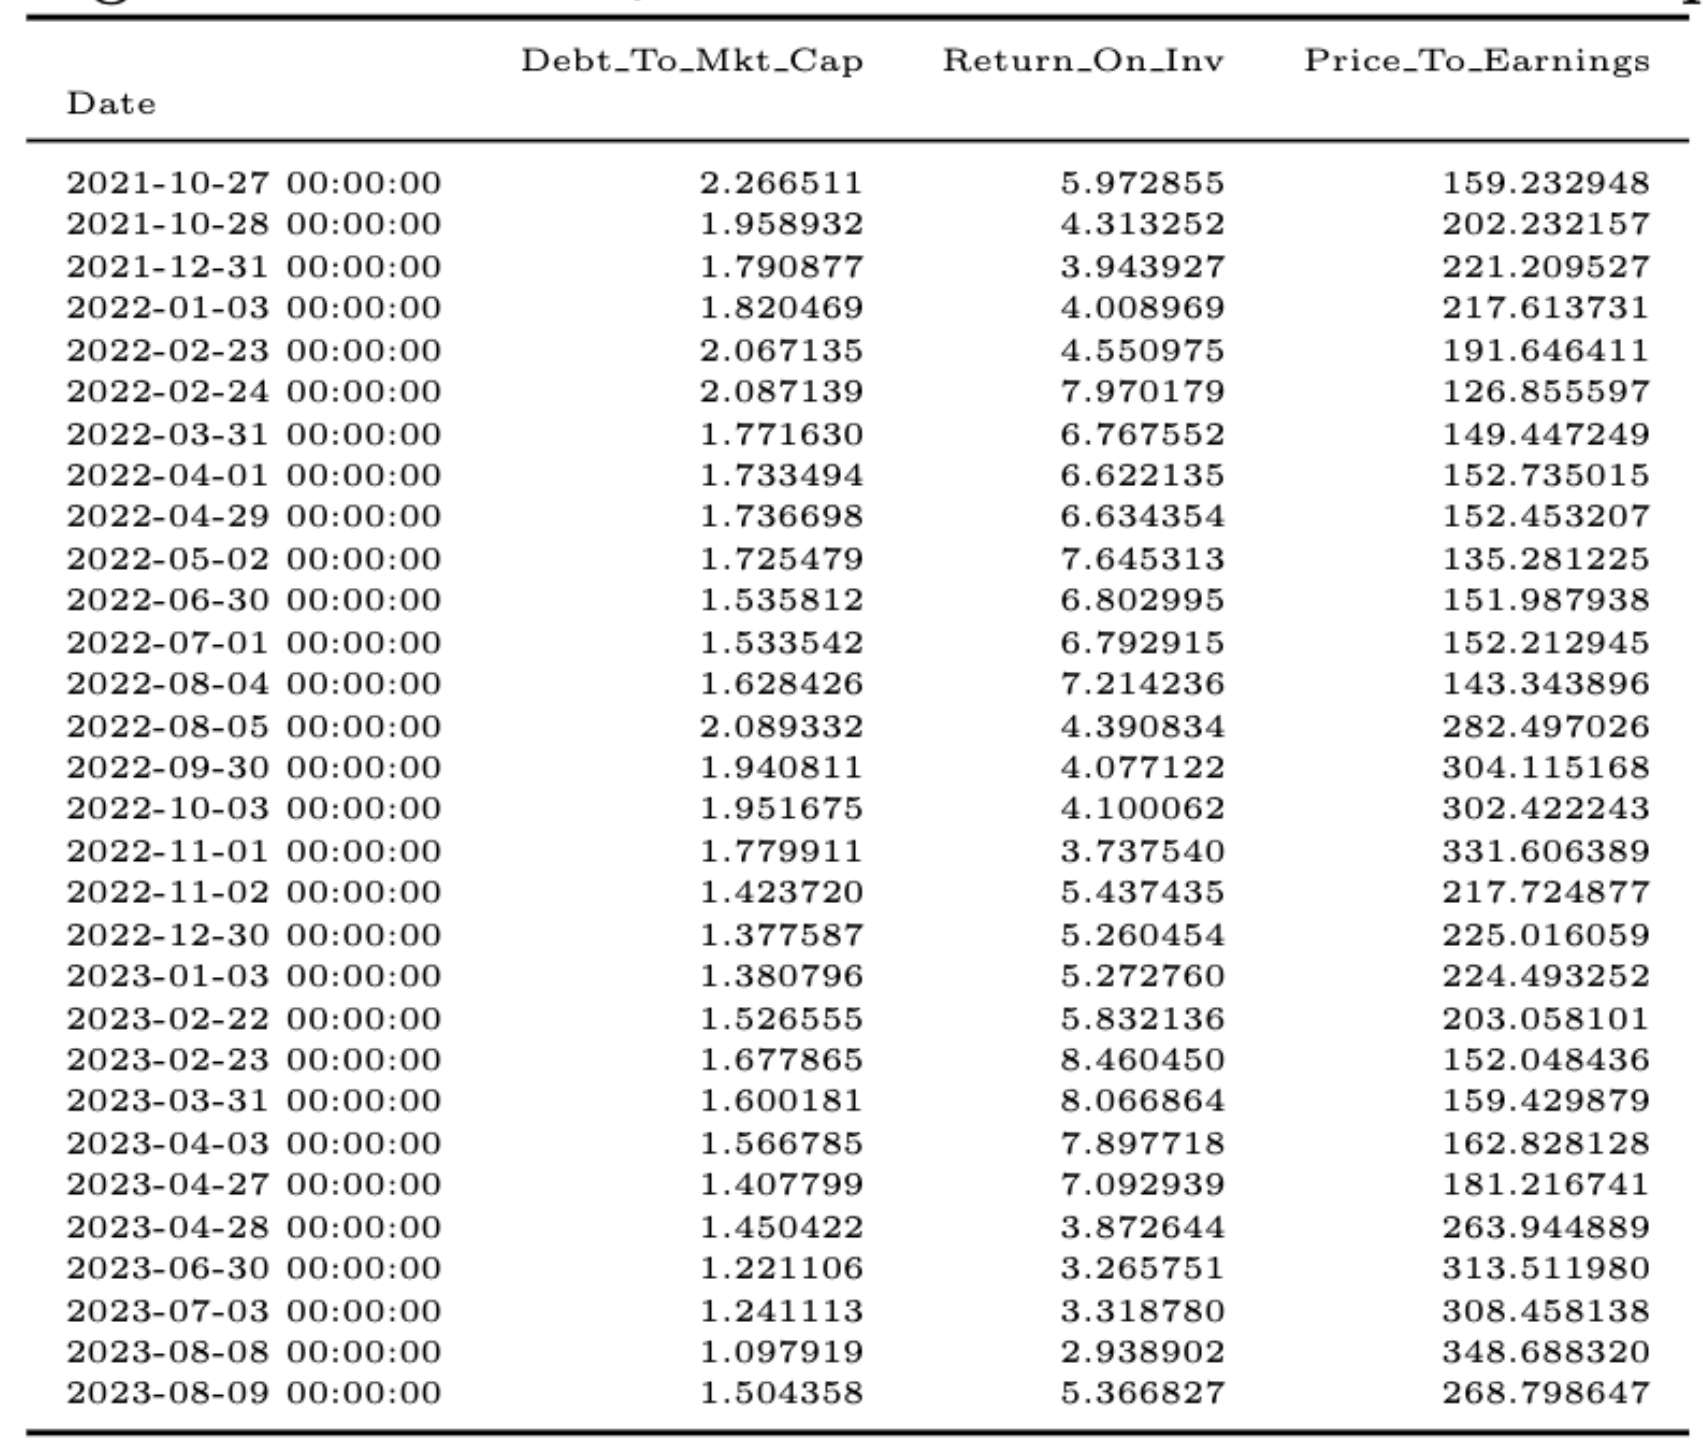

In [54]:
Image(filename='/Users/huayuzhu/Desktop/SampleRatioPostedonCanvas.jpg',width=700,height=1500)

## 4.Select Financial Ratios

In the preceding section, we employed the ticker symbol 'LLY' as a sample to assess the functions designed for calculating ratios. In this section, in order to enhance the implementation of the financial quantile ratio strategy, we will endeavor to store the financial ratios of various tickers in a dataframe and save it on the desktop for efficiency purposes.

### 4.1 Financial Ratio Calculation 

Here, we basically utilize the functions wrote above, and try to join the ratio information for all the tickers in the list into one dataframe. 

In [55]:
# get the df for debt to market ratio 
df_r1 = pd.DataFrame()
for ticker in list_filter_4:
    df_temp = debt_to_market_cap(ticker)
    df_r1 = df_r1.join(df_temp['debt_to_market_cap'], how = 'outer')
    df_r1 = df_r1.rename(columns={'debt_to_market_cap': ticker})

In [56]:
# get the df for return on investment ratio, price to earnings ratio, and adj_close price 
df_r2 = pd.DataFrame() 
df_r3 = pd.DataFrame()
df_price = pd.DataFrame()
for ticker in list_filter_4: 
    df_temp_2 = return_on_investment(ticker)
    df_r2 = df_r2.join(df_temp_2['return_on_investment'], how = 'outer')
    df_r2 = df_r2.rename(columns={'return_on_investment': ticker})

    df_temp_3 = price_to_earnings(ticker)
    df_r3 = df_r3.join(df_temp_3['price_to_earnings'], how = 'outer')
    df_r3 = df_r3.rename(columns={'price_to_earnings': ticker})

    df_temp_4 = get_adj_close_price(ticker)
    df_price = df_price.join(df_temp_4['adj_close'], how = 'outer')
    df_price = df_price.rename(columns={'adj_close': ticker})

In [ ]:
# here, we store those df in desktop. if re-run/ run in differet computer, the pathway can be changed 
df_price.to_csv('/Users/huayuzhu/Desktop/df_price_255.csv', index=False)
df_r1.to_csv('/Users/huayuzhu/Desktop/df_r1_255.csv', index=False)
df_r2.to_csv('/Users/huayuzhu/Desktop/df_r2_255.csv', index=False)
df_r3.to_csv('/Users/huayuzhu/Desktop/df_r3_255.csv', index=False)

### 4.2 Data Cleaning (A further filtration)

In this section, I have completed the final data cleaning process. Initially, I removed columns in which all values were missing, retaining only those columns with a limited number of NaN values. Subsequently, I addressed extreme or NaN values by filling them with the respective column's mean. There are 243 remaining tickers, which will be used in the trading strategy implemented below.

I will also do some refinement on the dataframes that will be used in analysis later and construct the return of tickers using adj_close for further usage. 

#### Drop NaN column 

In [58]:
df_r1.dropna(axis=1, how='all',inplace= True)
list_r1 = list(df_r1.dropna(axis=1, how='all').columns)

In [59]:
df_r2.dropna(axis = 1, how ='all',inplace = True)
list_r2 = list(df_r2.dropna(axis = 1, how ='all').columns)

In [60]:
df_r3.dropna(axis =1, how = 'all', inplace = True)
list_r3 = list(df_r3.dropna(axis = 1, how ='all').columns)

In [61]:
len(list_r1)

243

Here, we double check the list obtained by dropping NaN in three different ratio columns are the same. 

In [62]:
set1 = set(list_r1)
set2 = set(list_r2)
set3 = set(list_r3)
result = set2.issubset(set1)
result1 = set3.issubset(set1)
print(result)   
print(result1)

True
True


#### Fill NaN 

Double check whether there are Inf/NaN values in the table, and if there is, I will try to fill the missing and extreme values with the mean values. 

In [63]:
df_r1 = fill_nan(df_r1)
df_r2 = fill_nan(df_r2)
df_r3 = fill_nan(df_r3)
df_price = fill_nan(df_price)


In [64]:
tickers_list_f = list(df_r1.columns)

In [65]:
len(tickers_list_f)

243

#### Refinement on df 

Here, I quick check through the index and shape of each dataframe to ensure they have the same index in order for us to employ strategy later. 

In [66]:
tickers_list_f = sorted(tickers_list_f)

In [67]:
df_r1 = df_r1.sort_index(axis=1)
df_r2 = df_r2.sort_index(axis=1)
df_r3 = df_r3.sort_index(axis=1)
df_price = df_price.sort_index(axis=1)

In [68]:
print('Display of Debt Market Cap Ratio DataFrame:')
df_r1.head(3)

Display of Debt Market Cap Ratio DataFrame:


ACIW      ACNT       AEE      ALYA      ARAV      ASUR  \
2016-01-04  0.932058  0.543397  1.169518  0.323163  0.416719  1.743929   
2016-01-05  0.932058  0.543397  1.169518  0.323163  0.416719  1.743929   
2016-01-06  0.932058  0.543397  1.169518  0.323163  0.416719  1.743929   

                 ATI       AVA       AWR       CHD  ...      XXII       XYL  \
2016-01-04  1.243401  1.068282  0.778743  0.733486  ...  0.041338  0.778085   
2016-01-05  1.243401  1.068282  0.778743  0.733486  ...  0.041338  0.778085   
2016-01-06  1.243401  1.068282  0.778743  0.733486  ...  0.041338  0.778085   

               YELLQ      YORW       YUM       ZBH      ZBRA      ZEUS  \
2016-01-04 -3.734577  0.756173 -1.160506  0.782801  1.159872  0.695996   
2016-01-05 -3.734577  0.756173 -1.160506  0.782801  1.159872  0.695996   
2016-01-06 -3.734577  0.756173 -1.160506  0.782801  1.159872  0.695996   

                  ZG       ZTS  
2016-01-04  0.333069  2.080521  
2016-01-05  0.333069  2.080521  
2016-01-06  0.333069  2.080521  

[3 rows x 243 columns]

In [69]:
print('Display of Return on Investment DataFrame:')
df_r2.head(3)

Display of Return on Investment DataFrame:


ACIW      ACNT       AEE      ALYA       ARAV      ASUR  \
2016-01-04  0.784493  0.201034  1.176772 -5.514635 -75.892986 -1.841886   
2016-01-05  0.784493  0.201034  1.176772 -5.514635 -75.892986 -1.841886   
2016-01-06  0.784493  0.201034  1.176772 -5.514635 -75.892986 -1.841886   

                ATI       AVA       AWR      CHD  ...       XXII       XYL  \
2016-01-04 -1.53871  0.890675  1.795611  3.74055  ... -11.519881  1.707428   
2016-01-05 -1.53871  0.890675  1.795611  3.74055  ... -11.519881  1.707428   
2016-01-06 -1.53871  0.890675  1.795611  3.74055  ... -11.519881  1.707428   

               YELLQ     YORW        YUM       ZBH      ZBRA      ZEUS  \
2016-01-04 -2.553064  1.55089  11.129871  0.772446  2.870093  1.474455   
2016-01-05 -2.553064  1.55089  11.129871  0.772446  2.870093  1.474455   
2016-01-06 -2.553064  1.55089  11.129871  0.772446  2.870093  1.474455   

                 ZG       ZTS  
2016-01-04 -0.70261  3.987601  
2016-01-05 -0.70261  3.987601  
2016-01-06 -0.70261  3.987601  

[3 rows x 243 columns]

In [70]:
print('Display of Price to Earnings DataFrame:')
df_r3.head(3)

Display of Price to Earnings DataFrame:


ACIW         ACNT          AEE         ALYA          ARAV  \
2016-01-04  9229.68525  5333.690838  1391.218622  3027.206834  21720.349848   
2016-01-05  9229.68525  5333.690838  1391.218622  3027.206834  21720.349848   
2016-01-06  9229.68525  5333.690838  1391.218622  3027.206834  21720.349848   

                   ASUR          ATI          AVA         AWR          CHD  \
2016-01-04  6941.375978  7658.392457  1782.279143  129.746289  2358.706222   
2016-01-05  6941.375978  7658.392457  1782.279143  129.746289  2358.706222   
2016-01-06  6941.375978  7658.392457  1782.279143  129.746289  2358.706222   

            ...          XXII         XYL        YELLQ        YORW       YUM  \
2016-01-04  ...  25068.138697  235.972106  3579.425749  127.895701  97.80647   
2016-01-05  ...  25068.138697  235.972106  3579.425749  127.895701  97.80647   
2016-01-06  ...  25068.138697  235.972106  3579.425749  127.895701  97.80647   

                     ZBH          ZBRA        ZEUS            ZG         ZTS  
2016-01-04  22890.432638  19681.892788  4067.31057  33241.884536  156.378808  
2016-01-05  22890.432638  19681.892788  4067.31057  33241.884536  156.378808  
2016-01-06  22890.432638  19681.892788  4067.31057  33241.884536  156.378808  

[3 rows x 243 columns]

In [71]:
columns_to_drop = df_price.columns.difference(df_r1.columns)
df_price = df_price.drop(columns=columns_to_drop)

In [73]:
print('Display of Adjusted Close Price DataFrame:')
df_price.head(3)

Display of Adjusted Close Price DataFrame:


ACIW      ACNT        AEE      ALYA       ARAV  ASUR        ATI  \
date                                                                           
2016-01-04  20.67  6.676943  34.597306  6.387611  71.939856  4.52  11.305299   
2016-01-05  20.60  6.608612  35.007360  6.475142  71.819856  4.45  10.980604   
2016-01-06  20.50  6.432903  35.232488  6.451327  65.159870  4.45  10.527998   

                  AVA        AWR        CHD  ...       XXII        XYL  YELLQ  \
date                                         ...                                
2016-01-04  26.095374  35.046904  37.718404  ...  20.999999  32.658680  14.00   
2016-01-05  26.370846  35.297857  37.397723  ...  19.499999  32.649628  14.23   
2016-01-06  26.497414  35.782456  37.221575  ...  18.749999  32.242300  13.41   

                 YORW        YUM        ZBH   ZBRA       ZEUS     ZG  \
date                                                                   
2016-01-04  21.322282  44.692081  95.637814  66.49  11.158139  24.51   
2016-01-05  21.391175  44.580676  97.629290  64.82  11.091552  24.04   
2016-01-06  21.520349  44.265027  98.052009  62.23  11.091552  23.88   

                  ZTS  
date                   
2016-01-04  44.626467  
2016-01-05  45.325083  
2016-01-06  45.334524  

[3 rows x 243 columns]

In [74]:
df_r1 = df_r1[~df_r1.index.duplicated(keep='first')]
df_r2 = df_r2[~df_r2.index.duplicated(keep='first')]
df_r3 = df_r3[~df_r3.index.duplicated(keep='first')]

In [75]:
df_price.shape

(1906, 243)

In [76]:
df_r3.shape

(1906, 243)

In [77]:
df_return = df_price.pct_change(1).dropna()
print('Display of Return DataFrame:')
df_return.head(3)

Display of Return DataFrame:


ACIW      ACNT       AEE      ALYA      ARAV      ASUR  \
date                                                                     
2016-01-05 -0.003387 -0.010234  0.011852  0.013703 -0.001668 -0.015487   
2016-01-06 -0.004854 -0.026588  0.006431 -0.003678 -0.092732  0.000000   
2016-01-07 -0.043902  0.003020  0.000685 -0.018519 -0.117864 -0.020225   

                 ATI       AVA       AWR       CHD  ...      XXII       XYL  \
date                                                ...                       
2016-01-05 -0.028721  0.010556  0.007160 -0.008502  ... -0.071429 -0.000277   
2016-01-06 -0.041219  0.004800  0.013729 -0.004710  ... -0.038462 -0.012476   
2016-01-07 -0.110280 -0.003372 -0.020798 -0.016139  ... -0.176000 -0.025828   

               YELLQ      YORW       YUM       ZBH      ZBRA      ZEUS  \
date                                                                     
2016-01-05  0.016429  0.003231 -0.002493  0.020823 -0.025117 -0.005968   
2016-01-06 -0.057625  0.006039 -0.007080  0.004330 -0.039957  0.000000   
2016-01-07 -0.071588 -0.014806 -0.034116 -0.022993 -0.045316 -0.057461   

                  ZG       ZTS  
date                            
2016-01-05 -0.019176  0.015655  
2016-01-06 -0.006656  0.000208  
2016-01-07 -0.036013 -0.030404  

[3 rows x 243 columns]

### 4.2 Understanding Selected Tickers 

In this section, my intention is to perform an analysis of the tickers that have been filtered/ selected in the preceding section. Gaining a deeper insight into the defined universe of tickers will enhance our ability to construct and comprehend the trading strategy that will be subsequently implemented.

#### Industry Bar Plot 

The tickers we selected are distributed unevenly in different sectors. We can tell that Computer and Technology & Medical takes up a large proportion. Our data focuses on several industries and is not evenly distributed. From my intuition, for different industries, some ratio maybe more important than others. If I need to improve the trading strategy, I may need to consider this fact. I need to conduct a deep research about the impact and consider a more complicated way to conduct the ranking process.  

In [78]:
filtered_df_MT = df_MT[df_MT['ticker'].isin(tickers_list_f)]

In [79]:
sector_counts = filtered_df_MT['zacks_x_sector_desc'].value_counts()
fig = go.Figure()
fig.add_trace(
    go.Bar(x=sector_counts.index, y=sector_counts.values, name='Industry of Selected tickers'),
)

fig.update_layout(
    title='Ticker Count by Industry Sector',
    xaxis_title='Industry Sector',
    yaxis_title='Ticker Count',
    template="none",
    autosize=True, 
    showlegend=True,
)

fig.show()

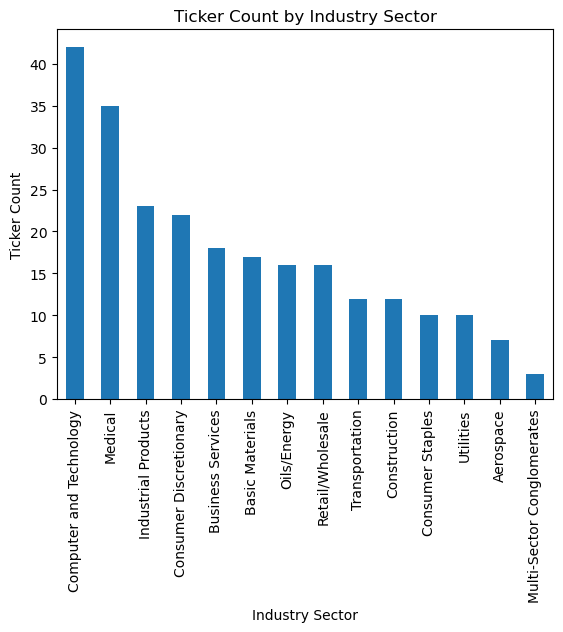

In [81]:
sector_counts.plot(kind='bar')

plt.xlabel('Industry Sector')
plt.ylabel('Ticker Count')
plt.title('Ticker Count by Industry Sector')

#plt.xticks(rotation=45)   
plt.show()

#### Descriptive Statistics for Selected Tickers 

Based on the descriptive statistics of the selected tickers, it becomes evident that certain equities exhibit significantly higher prices. Consequently, when implementing these equities in our trading strategy, we must factor in this price discrepancy. Similar to the uneven distribution of industries within our portfolio, the disparity in stock prices can significantly influence our trading strategy. This disparity will invariably impact position sizing and the resulting profit and loss (PnL) when we allocate capital to both expensive and less expensive stocks.

One potential avenue for investigation is to explore the effects of defining a trading universe based on equity prices. This could involve creating a universe composed of equities with similar price levels, whether they are predominantly high or low-priced, or a universe that deliberately encompasses equities with a wide range of price points. Analyzing the performance and outcomes of these different universes can provide insights into how stock price ranges influence returns and help optimize our trading approach.

Similar situation happen with the three ratios, but since we are selecting based on rank, maybe the disparity in ratios do not lead to a huge effect. 

In [82]:
print('Summary statistics table for adjusted close prices:')
summary_stats_table(df_price)

Summary statistics table for adjusted close prices:


Mean  Standard deviation  VaR (0.05)  Quantile 0.25   Median  \
ACIW   27.207               6.041      18.822         22.542   26.240   
ACNT   12.229               3.988       6.707          9.171   11.470   
AEE    64.271              15.934      39.644         49.033   66.872   
ALYA    3.569               1.639       1.700          2.262    2.850   
ARAV   23.460              34.424       1.072          3.792    6.520   
...       ...                 ...         ...            ...      ...   
ZBH   122.415              17.217      97.742        110.518  119.146   
ZBRA  239.997             147.446      62.805        109.450  209.255   
ZEUS   21.976               9.711      10.068         15.504   20.423   
ZG     53.615              31.018      27.912         35.205   42.470   
ZTS   116.764              52.396      44.876         68.032  118.932   

      Quantile 0.75  Skewness  Excess Kurtosis     Min      Max  
ACIW         31.795     0.448           -0.711  16.230   43.100  
ACNT         15.258     0.471           -0.322   3.920   24.177  
AEE          78.453    -0.122           -1.254  33.874   93.658  
ALYA          5.111     0.670           -0.911   1.230    7.407  
ARAV         13.792     1.673            1.405   0.610  138.300  
...             ...       ...              ...     ...      ...  
ZBH         133.303     0.604           -0.009  78.233  174.926  
ZBRA        306.150     0.792           -0.232  46.930  614.550  
ZEUS         25.699     1.300            1.742   7.636   58.309  
ZG           55.955     1.974            3.540  17.060  203.790  
ZTS         161.192     0.131           -1.225  37.212  242.468  

[243 rows x 10 columns]

In [83]:
print('Summary statistics table for debt market ratio:')
summary_stats_table(df_r1)

Summary statistics table for debt market ratio:


Mean  Standard deviation  VaR (0.05)  Quantile 0.25  Median  \
ACIW  0.931               0.250       0.543          0.793   0.932   
ACNT  0.543               0.280       0.085          0.330   0.528   
AEE   1.170               0.169       0.935          1.038   1.167   
ALYA  0.323               0.170       0.073          0.166   0.352   
ARAV  0.418               0.589       0.057          0.085   0.192   
...     ...                 ...         ...            ...     ...   
ZBH   0.784               0.269       0.399          0.601   0.682   
ZBRA  1.162               0.820       0.366          0.591   0.879   
ZEUS  0.696               0.237       0.252          0.563   0.706   
ZG    0.333               0.246       0.082          0.154   0.309   
ZTS   2.083               0.531       1.349          1.642   2.081   

      Quantile 0.75  Skewness  Excess Kurtosis    Min    Max  
ACIW          1.088     0.911            3.159  0.474  2.173  
ACNT          0.739     0.388           -0.292  0.071  1.532  
AEE           1.284     0.465           -0.102  0.816  1.749  
ALYA          0.450     0.155           -1.105  0.065  0.827  
ARAV          0.417     3.015           10.123  0.041  3.724  
...             ...       ...              ...    ...    ...  
ZBH           1.023     0.664           -0.325  0.345  1.577  
ZBRA          1.160     1.300            0.380  0.295  3.557  
ZEUS          0.826    -0.059            0.155  0.124  1.422  
ZG            0.389     1.997            4.946  0.055  1.482  
ZTS           2.421     0.562           -0.028  1.105  3.666  

[243 rows x 10 columns]

In [84]:
print('Summary statistics table for return on investment ratio:')
summary_stats_table(df_r2)

Summary statistics table for return on investment ratio:


Mean  Standard deviation  VaR (0.05)  Quantile 0.25  Median  \
ACIW   0.788               1.996      -1.723         -0.733   0.534   
ACNT   0.195               2.623      -4.862         -1.034   0.201   
AEE    1.177               0.612       0.258          0.775   1.110   
ALYA  -5.510               4.902     -13.820         -8.744  -6.202   
ARAV -76.123             116.863    -225.397        -75.893 -55.334   
...      ...                 ...         ...            ...     ...   
ZBH    0.772               1.476      -1.992          0.500   0.875   
ZBRA   2.865               2.419      -1.909          1.405   2.870   
ZEUS   1.468               2.070      -0.537          0.109   0.937   
ZG    -0.704               1.325      -2.526         -1.102  -0.505   
ZTS    3.989               1.032       2.518          3.441   3.941   

      Quantile 0.75  Skewness  Excess Kurtosis      Min      Max  
ACIW          1.092     1.237            1.335   -2.192    7.292  
ACNT          1.830    -0.084            0.393   -7.557    6.709  
AEE           1.738     0.183            0.113   -0.411    2.741  
ALYA         -0.265    -0.323           -0.775  -26.844    1.739  
ARAV        -29.901    -2.535           10.476 -640.603  243.645  
...             ...       ...              ...      ...      ...  
ZBH           1.060     0.823            7.292   -3.934    7.316  
ZBRA          3.763    -0.057           -0.178   -2.625    9.282  
ZEUS          2.019     1.310            0.858   -1.299    7.796  
ZG            0.187    -2.165            6.284   -6.473    0.900  
ZTS           4.584    -0.037            1.644    0.862    7.170  

[243 rows x 10 columns]

In [85]:
print('Summary statistics table for price to earnings ratio:')
summary_stats_table(df_r3)

Summary statistics table for price to earnings ratio:


Mean  Standard deviation  VaR (0.05)  Quantile 0.25     Median  \
ACIW   9244.851           12270.030      32.006        133.000    316.115   
ACNT   5328.830            5634.570      15.517         47.478   5333.691   
AEE    1400.814            7664.952      39.737         50.180     86.337   
ALYA   3028.631            1369.593    1580.000       2180.000   2800.000   
ARAV  21805.106           33822.459     899.775       3505.000   6290.000   
...         ...                 ...         ...            ...        ...   
ZBH   23057.234           47268.111      68.968        123.990    153.877   
ZBRA  19609.788           57558.493      72.622         94.360    136.313   
ZEUS   4085.013            7592.099       7.430         17.837     64.752   
ZG    33367.956           22896.590     607.667       2368.500  36170.000   
ZTS     156.385              64.699     107.570        121.728    146.583   

      Quantile 0.75  Skewness  Excess Kurtosis      Min         Max  
ACIW      22042.500     0.862           -0.820   25.054   39930.000  
ACNT       9712.805     0.531           -1.039   12.519   19500.000  
AEE         115.053     5.994           34.047   25.935   50998.968  
ALYA       3317.500     0.808            0.861   83.252    7080.531  
ARAV      13792.479     1.858            2.021    1.718  138299.723  
...             ...       ...              ...      ...         ...  
ZBH        1454.526     1.700            0.978   16.639  145622.608  
ZBRA       1906.214     3.909           15.637   52.269  349410.000  
ZEUS       4067.311     1.701            1.487    5.145   29682.630  
ZG        46657.500     0.095            0.013  481.500  110260.000  
ZTS         167.280     3.999           18.584   96.862     516.029  

[243 rows x 10 columns]

#### Relationship between ratios and return 

In this study, I have explored the relationship between equity performance and returns, offering valuable insights for individuals who may not possess an extensive understanding of financial ratios. To assess this relationship, I have employed a straightforward linear regression analysis, examining the impact of three key ratios: IOR (Interest on Revenue), PTE (Profitability to Equity), and the Debt-Market-Cap Ratio.

As my dataset comprises data from over 200 different tickers, I have initially conducted a broad overview by calculating descriptive statistics. While these statistics provide a foundational understanding, there is room for improvement to gain more nuanced insights.

One intriguing observation from the initial analysis is that the Debt-Market-Cap Ratio exhibits predominantly positive beta coefficients, whereas the other two ratios display negative betas. This observation appears to defy conventional wisdom. To delve deeper into this anomaly, I have conducted a pairwise investigation, which has yielded results consistent with the initial findings.

Given these findings, my strategy development approach will initially align with conventional practices. However, I intend to further explore the implications of the relationships I have uncovered to determine which approach ultimately yields superior results.

In [86]:
PTE_aligned = df_r1.loc[df_return.index, df_return.columns]
ROI_aligned = df_r2.loc[df_return.index, df_return.columns]
Debt_MC_aligned = df_r3.loc[df_return.index, df_return.columns]

results = []  
for ticker in df_return.columns:

    x_data = pd.DataFrame({
        'PTE': PTE_aligned[ticker],
        'ROI': ROI_aligned[ticker],
        'Debt_MC': Debt_MC_aligned[ticker]
    })
    y_data = df_return[ticker]

    dataset = pd.concat([x_data, y_data], axis=1).dropna()
    
    X = sm.add_constant(dataset[['PTE', 'ROI', 'Debt_MC']])
    y = dataset[ticker]
    
    model = sm.OLS(y, X).fit()

    results.append({
        'Ticker': ticker,
        'coef_PTE': model.params['PTE'],
        'coef_ROI': model.params['ROI'],
        'coef_Debt_MC': model.params['Debt_MC'],
        'pvalue_PTE': model.pvalues['PTE'],
        'pvalue_ROI': model.pvalues['ROI'],
        'pvalue_Debt_MC': model.pvalues['Debt_MC'],
        'R_squared': model.rsquared
    })

results_df = pd.DataFrame(results)
results_df

Ticker  coef_PTE  coef_ROI  coef_Debt_MC  pvalue_PTE  pvalue_ROI  \
0     ACIW -0.006077 -0.000230 -3.632218e-08    0.004073    0.488674   
1     ACNT -0.009452 -0.000281  2.278636e-08    0.000688    0.434329   
2      AEE -0.005961 -0.000916 -3.050236e-08    0.002365    0.124234   
3     ALYA  0.029844  0.000959  1.454724e-06    0.264068    0.223707   
4     ARAV -0.001343  0.000007  5.530127e-08    0.548350    0.557059   
..     ...       ...       ...           ...         ...         ...   
238    ZBH -0.002241 -0.000189 -2.525494e-09    0.153611    0.603027   
239   ZBRA -0.002076 -0.001344 -3.305940e-08    0.052719    0.001744   
240   ZEUS -0.014874 -0.000243 -2.810097e-08    0.000048    0.599206   
241     ZG -0.009127  0.000519  5.931824e-08    0.006461    0.433431   
242    ZTS -0.002346 -0.001722 -1.494674e-05    0.005184    0.000326   

     pvalue_Debt_MC  R_squared  
0          0.504121   0.004691  
1          0.891910   0.006236  
2          0.521000   0.005572  
3          0.187874   0.001489  
4          0.131879   0.001847  
..              ...        ...  
238        0.824468   0.001357  
239        0.009655   0.005632  
240        0.823414   0.009521  
241        0.109763   0.005231  
242        0.039278   0.007405  

[243 rows x 8 columns]

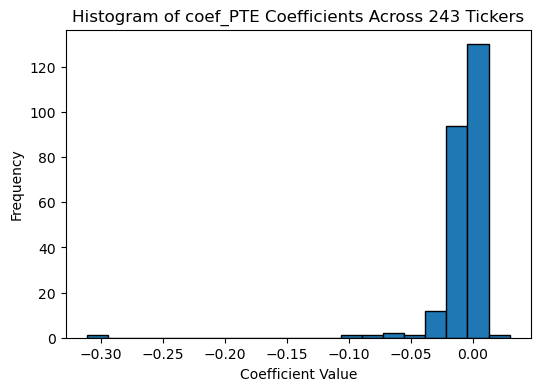

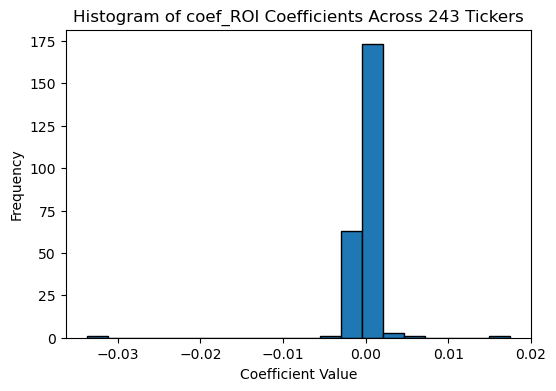

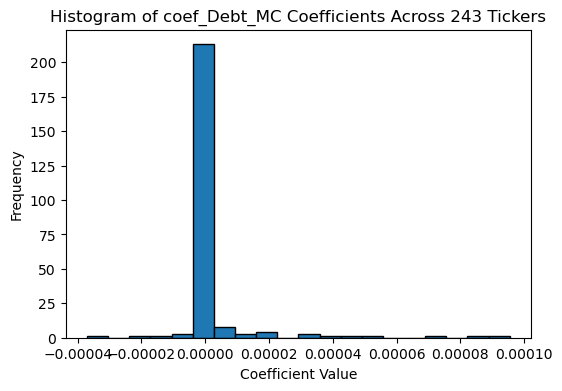

In [87]:
for ratio in ['coef_PTE', 'coef_ROI', 'coef_Debt_MC']:
    plt.figure(figsize=(6, 4))
    plt.hist(results_df[ratio], bins=20, edgecolor='black')
    plt.title(f'Histogram of {ratio} Coefficients Across 243 Tickers')
    plt.xlabel('Coefficient Value')
    plt.ylabel('Frequency')
    plt.show()


In [88]:
summary_stats = results_df[['coef_PTE', 'coef_ROI', 'coef_Debt_MC']].describe()
print(summary_stats)

         coef_PTE    coef_ROI  coef_Debt_MC
count  243.000000  243.000000  2.430000e+02
mean    -0.008017   -0.000312  2.252997e-06
std      0.023068    0.002579  1.176622e-05
min     -0.311307   -0.033730 -3.706201e-05
25%     -0.008897   -0.000509 -3.423878e-08
50%     -0.003690   -0.000096  9.834360e-09
75%     -0.000321    0.000053  1.835136e-07
max      0.029844    0.017443  9.548257e-05


In [89]:
results = []  
for ticker in df_return.columns:

    x_data = pd.DataFrame({
        'PTE': PTE_aligned[ticker]
    })
    y_data = df_return[ticker]

    dataset = pd.concat([x_data, y_data], axis=1).dropna()
    
    X = sm.add_constant(dataset[['PTE']])
    y = dataset[ticker]
    
    model = sm.OLS(y, X).fit()

    results.append({
        'Ticker': ticker,
        'coef_PTE': model.params['PTE']
    })

results_df = pd.DataFrame(results)
results_df

Ticker  coef_PTE
0     ACIW -0.006019
1     ACNT -0.009026
2      AEE -0.005576
3     ALYA -0.004582
4     ARAV -0.002008
..     ...       ...
238    ZBH -0.002333
239   ZBRA  0.000307
240   ZEUS -0.015121
241     ZG -0.008765
242    ZTS -0.000769

[243 rows x 2 columns]

In [90]:
results_df.describe()

coef_PTE
count  243.000000
mean    -0.007704
std      0.019000
min     -0.202255
25%     -0.007529
50%     -0.003358
75%     -0.000537
max      0.004890

In [91]:
results = []  
for ticker in df_return.columns:

    x_data = pd.DataFrame({
        'ROI': ROI_aligned[ticker]
    })
    y_data = df_return[ticker]

    dataset = pd.concat([x_data, y_data], axis=1).dropna()
    
    X = sm.add_constant(dataset[['ROI']])
    y = dataset[ticker]
    
    model = sm.OLS(y, X).fit()

    results.append({
        'Ticker': ticker,
        'coef_ROI': model.params['ROI']
    })

results_df = pd.DataFrame(results)
results_df

Ticker  coef_ROI
0     ACIW -0.000197
1     ACNT -0.000172
2      AEE -0.000612
3     ALYA  0.000172
4     ARAV  0.000009
..     ...       ...
238    ZBH -0.000206
239   ZBRA -0.000397
240   ZEUS -0.000523
241     ZG -0.000293
242    ZTS -0.000844

[243 rows x 2 columns]

In [92]:
results_df.describe()

coef_ROI
count  243.000000
mean    -0.000163
std      0.002202
min     -0.004903
25%     -0.000483
50%     -0.000115
75%      0.000026
max      0.032187

In [93]:
results = []  
for ticker in df_return.columns:

    x_data = pd.DataFrame({
        'Debt_MC': Debt_MC_aligned[ticker]
    })
    y_data = df_return[ticker]

    dataset = pd.concat([x_data, y_data], axis=1).dropna()
    
    X = sm.add_constant(dataset[['Debt_MC']])
    y = dataset[ticker]
    
    model = sm.OLS(y, X).fit()

    results.append({
        'Ticker': ticker,
        'coef_Debt_MC': model.params['Debt_MC']
    })

results_df = pd.DataFrame(results)
results_df

Ticker  coef_Debt_MC
0     ACIW  8.696797e-09
1     ACNT  2.908337e-08
2      AEE  9.784459e-09
3     ALYA  6.718807e-07
4     ARAV  5.737364e-08
..     ...           ...
238    ZBH  3.568764e-09
239   ZBRA -7.472609e-09
240   ZEUS  8.609413e-08
241     ZG  5.538479e-08
242    ZTS  1.678566e-06

[243 rows x 2 columns]

In [94]:
results_df.describe()

coef_Debt_MC
count  2.430000e+02
mean   3.112473e-06
std    1.049800e-05
min   -6.967148e-07
25%    5.111022e-09
50%    5.374233e-08
75%    3.132561e-07
max    7.503776e-05

## 5.Trading Strategy 

In this secion, I will try to implement the quantile trading strategy. Basically, we will try to use a ratio to rank the tickers and trade the equities that are beyound upperthreshold and lower than the lower threshold. We will hold the position until one period end. In this process, there are some parameters we need to decide: 

* ratio used for ranking the tickers 
* ways of deciding how to rank tickers 
* time period we need to hold/adjust our position 
* the strategy (Short Top Long Bottom or Short Bottom Long Top) 
* how much equities we need to use (percentile)
* positions sizing  

Based on those, we will test our performance and to check in which way we will have the best result: 

### 5.1 Common Three Ratio Trial 

In this part, we will focus on the three ratios individually. 

**Debt-to-Market Cap Ratio:**

From the intuition, a high debt-to-market cap ratio indicates that a company is more leveraged, which could be seen as riskier since it has more debt relative to its size. However, in some industries, higher leverage is common and not necessarily a sign of poor health. I expect that companies with lower debt-to-market cap ratios could be more resilient in downturns, whereas those with higher ratios might have more volatile stock prices. In addition, from previous linear regression test, we can see a negative correlation between the return and the Debt Market Cap Ratio. 

**Return on Investment (ROI):**

ROI measures the profitability of an investment relative to its cost. A high ROI indicates that the investment’s gains compare favorably to its cost. Supposingly, if we assume that companies use the investment wisely and can generate the profits from investment, we should see a positive beta. However, we see a negative beta is previous test. Suggesting that our data may be different from common perception. 

**Price-to-Earnings (PTE) Ratio:** 
It compares a company's share price to its earnings per share. A high P/E ratio could mean that a company's stock is overvalued, or investors are expecting high growth rates in the future. Stocks with low P/E ratios could be undervalued or viewed as having lower growth prospects. It is the only one ratio exhibts the positive beta in the previous part. 

**Strategy Used - Long Bottom Short Top vs. Long Top Short Bottom:**

Long Bottom Short Top: The hypothesis is that the lowest quantile is undervalued and the highest is overvalued, and I expect a reversion to the mean.

Long Top Short Bottom: Conversely, this strategy expects high ratio companies will continue to perform well, while low ratio companies will continue to underperform.

**strategy choosing:**

Since I do not have a lot of understandings about the market condition and the tickers chosen, I would test various parameters and strategy in the trading strategy and do analysis based on the result. 



The study follows a structure listed below: 
1. common three ratio tests, Long Bottom Short Top
2. Long Top Short Bottom 
3. Ranked base on difference in ratios 
4. Time we take to re-adjust our position
5. percentile change 
6. position size change 

For each test, we will specify its parameters when defining variables, the notation used is down below. 

Notation: 
* r1, r2, r3: 3 different ratios 
* M, W, D: time period 
* s1, s2: strategy Long Bottom Short Top 
* d0, d1: rank based on themselves, rank based on difference 
* p0,p1: position size. doubling the most attractive vigintiles 
* num: percentage taken 

For the funding rate, we set it as the LIBOR.

In [95]:
LIBOR = 4.35 

#### 5.1.1 Common Three Ratio Trial - Long Top Short Bottom 

The strategies vary considerably in their risk-adjusted performance and their responses to market downturns. The Price to Earnings strategy appears to be the most successful of the three, with positive returns and the lowest risk metrics. Downside beta across all strategies is low, indicating a degree of protection during market downturns. We may consider changing to Long Bottom Short Top for first two ratios. 

Debt Market Cap Ratio Strategy (r1_M_s1_d0_p0_010):

- This strategy has a slightly negative mean return, indicating that, on average, the strategy loses money.
- The volatility is relatively low, suggesting that the returns do not fluctuate wildly.
- The negative Sharpe ratios (both against a risk-free benchmark and the market) suggest that the excess returns of the strategy, when adjusted for risk, are poor.
- The Sortino ratio is also negative, which similarly indicates poor performance when considering only downside risk.
- A maximum drawdown near -1 suggests that at one point, the strategy nearly lost its entire value, which is a significant risk.
- The final cumulative return is slightly negative, showing a loss over the period analyzed.
- The Calmar ratio is very low, which indicates that the return generated per unit of drawdown risk is low.
- A low downside beta suggests that the strategy does not move much in response to downward market moves, which could be a positive if the market is falling.

Return on Investment Strategy (r2_M_s1_d0_p0_010):

- The mean return is negative, though the absolute value is smaller than the Debt Market Cap Ratio strategy, indicating slightly better performance.
- It has a low volatility, similar to the first strategy.
- The Sharpe and Sortino ratios are negative, again indicating a lack of excess return for the risk taken.
- The maximum drawdown is close to -1, like the first strategy, suggesting a potential for total loss.
- The final cumulative return is slightly negative.
- A very low downside beta indicates the strategy has a minimal correlation with the market when the market is down.
- The positive Calmar ratio suggests that despite the risks, the strategy has a better return per unit of drawdown risk compared to the Debt Market Cap Ratio strategy.

Price to Earnings Strategy (r3_M_s1_d0_p0_010):

- This strategy shows a positive mean return, which indicates profitability.
- The volatility is the lowest among the three strategies, which suggests less risk of fluctuating returns.
- The positive Sharpe ratio (against the market as the benchmark) suggests that the strategy generates excess returns when adjusted for market risk.
- The Sortino ratio is negative, which suggests that the strategy doesn't perform well when only considering downside risk.
- The maximum drawdown is considerable but less than the previous strategies, indicating a lower risk of a significant loss.
- A positive final cumulative return suggests that the strategy generated a profit over the period analyzed.
- The positive Calmar ratio is higher than the other strategies, indicating a better return per unit of drawdown risk.
- The low downside beta suggests that the strategy is less sensitive to market downturns.

* **Debt Market Cap Ratio**

In [96]:
r1_M_s1_d0_p0_010 = quantile_trading_strategy(df_r1,df_price,LIBOR,0.1,'M',False,False,1)
metrics_derived_from_return_series(r1_M_s1_d0_p0_010,ff_factors,'r1_M_s1_d0_p0_010')

mean  volatility  sharpe ratio (benchmark = 0)  \
r1_M_s1_d0_p0_010 -0.000216     0.05641                     -0.003834   

                   sharpe ratio (benchmark = rf)  \
r1_M_s1_d0_p0_010                       -0.09265   

                   sharpe ratio (benchmark = mkt)  sortino ratio       min  \
r1_M_s1_d0_p0_010                       -0.037945      -0.588869 -0.997391   

                        max  max drawdown  downside beta       VaR  \
r1_M_s1_d0_p0_010  0.351527      -0.99993       0.002323 -0.050039   

                   CVaR (0.05)      Skew   Kurtosis  Calmar Ratio  \
r1_M_s1_d0_p0_010    -0.124933 -5.861698  100.40513      0.005267   

                   final cumulative return  
r1_M_s1_d0_p0_010                -0.009999

* **Return on Investment** 

In [97]:
r2_M_s1_d0_p0_010 = quantile_trading_strategy(df_r2,df_price,LIBOR,0.1,'M',False,False,1)
metrics_derived_from_return_series(r2_M_s1_d0_p0_010,ff_factors,'r2_M_s1_d0_p0_010')

mean  volatility  sharpe ratio (benchmark = 0)  \
r2_M_s1_d0_p0_010 -0.001872    0.050818                     -0.036834   

                   sharpe ratio (benchmark = rf)  \
r2_M_s1_d0_p0_010                      -0.134999   

                   sharpe ratio (benchmark = mkt)  sortino ratio       min  \
r2_M_s1_d0_p0_010                       -0.039607      -0.739991 -0.863086   

                        max  max drawdown  downside beta       VaR  \
r2_M_s1_d0_p0_010  0.590777     -0.999132       0.001084 -0.056486   

                   CVaR (0.05)      Skew   Kurtosis  Calmar Ratio  \
r2_M_s1_d0_p0_010    -0.118541 -2.343841  72.611328      0.006928   

                   final cumulative return  
r2_M_s1_d0_p0_010                 -0.00999

* **Price to Earnings**

In [98]:
r3_M_s1_d0_p0_010 = quantile_trading_strategy(df_r3,df_price,LIBOR,0.1,'M',False,False,1)
metrics_derived_from_return_series(r3_M_s1_d0_p0_010,ff_factors,'r3_M_s1_d0_p0_010')

mean  volatility  sharpe ratio (benchmark = 0)  \
r3_M_s1_d0_p0_010  0.001955    0.033708                      0.058001   

                   sharpe ratio (benchmark = rf)  \
r3_M_s1_d0_p0_010                      -0.089769   

                   sharpe ratio (benchmark = mkt)  sortino ratio       min  \
r3_M_s1_d0_p0_010                       -0.035747      -0.997475 -0.551876   

                        max  max drawdown  downside beta       VaR  \
r3_M_s1_d0_p0_010  0.319149     -0.571677      -0.000246 -0.038149   

                   CVaR (0.05)      Skew   Kurtosis  Calmar Ratio  \
r3_M_s1_d0_p0_010    -0.081056 -2.791282  58.251297      0.005415   

                   final cumulative return  
r3_M_s1_d0_p0_010                 0.114203

* **Comparison**

In [99]:
r1_trail = list() 
r2_trail = list() 
r3_trail = list() 

m1_trail = list() 

r1_trail.append(r1_M_s1_d0_p0_010.loc[:,['cumulative_return']].rename(columns= {'cumulative_return':'r1_M_s1_d0_p0_010'}))
r2_trail.append(r2_M_s1_d0_p0_010.loc[:,['cumulative_return']].rename(columns= {'cumulative_return':'r2_M_s1_d0_p0_010'}))
r3_trail.append(r3_M_s1_d0_p0_010.loc[:,['cumulative_return']].rename(columns= {'cumulative_return':'r3_M_s1_d0_p0_010'}))
m1_trail.append(r1_M_s1_d0_p0_010.loc[:,['net_return']].rename(columns= {'net_return':'r1_M_s1_d0_p0_010'}))
m1_trail.append(r2_M_s1_d0_p0_010.loc[:,['net_return']].rename(columns= {'net_return':'r2_M_s1_d0_p0_010'}))
m1_trail.append(r3_M_s1_d0_p0_010.loc[:,['net_return']].rename(columns= {'net_return':'r3_M_s1_d0_p0_010'}))

In [100]:
m1_trail_s = []
m1_trail_s.append(r1_M_s1_d0_p0_010.loc[:,['cumulative_return']].rename(columns= {'cumulative_return':'r1_M_s1_d0_p0_010'}))
m1_trail_s.append(r2_M_s1_d0_p0_010.loc[:,['cumulative_return']].rename(columns= {'cumulative_return':'r2_M_s1_d0_p0_010'}))
m1_trail_s.append(r3_M_s1_d0_p0_010.loc[:,['cumulative_return']].rename(columns= {'cumulative_return':'r3_M_s1_d0_p0_010'}))

The plot looks quite concerning. It seems like around the end of 2016 and start of 2017, there are extreme returns. The cumulative return plot also shows that the result does not look good for the first two. However, the value is relatively small. 

In [101]:
df_m1_s = pd.concat(m1_trail_s,axis =1 )
return_plot(df_m1_s,ret=2)

In [102]:
df_m1 = pd.concat(m1_trail,axis =1)
return_plot(df_m1)

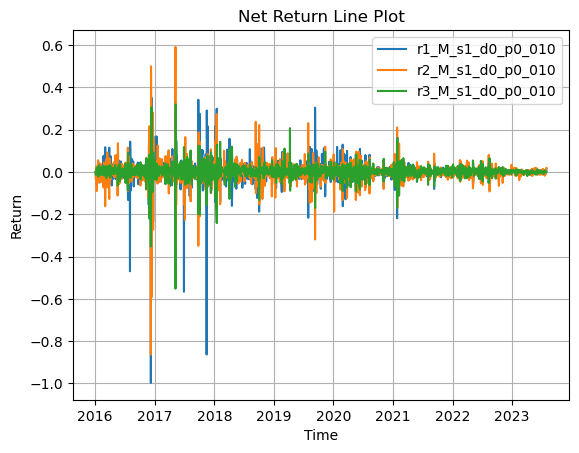

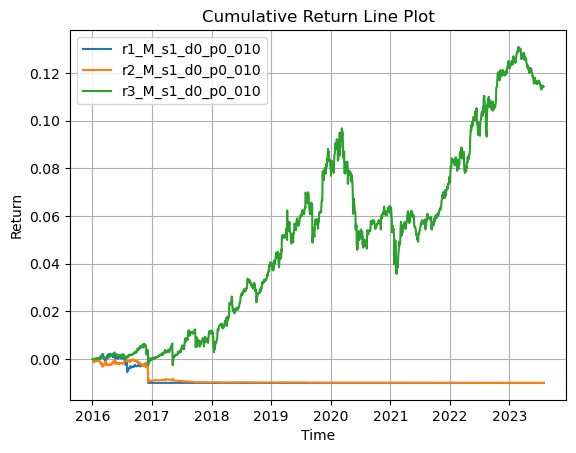

In [186]:
draw_ret_plt(df_m1)
draw_ret_plt(df_m1_s,ret =2)

#### 5.1.2 Long Bottom Short Top 

This part suggests the PTE is suitable for Long Top Short Bottom, which seems to have some degree of relationship with the linear regression we conducted before. The effect of changing strategy for debt market cap ratio is still debating and need to conduct other test. Also, it's quite concering that all of them have a high skewness and kurtosis.A very high positive skew suggests that while the strategy mostly yields small losses, there is a potential for occasional large gains. Extremely high kurtosis indicates that the distribution of returns has fat tails and is prone to outlier events, which can be both very negative and very positive. 

Other metrics are quite similar with the metrics obtained in 5.1.1, so I did not conduct a detailed analysis around it. 

* **Debt Market Cap Ratio**

In [105]:
m2 = list() 
m2_s = list() 

In [106]:
r1_M_s2_d0_p0_010 = quantile_trading_strategy(df_r1,df_price,LIBOR,0.1,'M',False,False,strat=-1)
metrics_derived_from_return_series(r1_M_s2_d0_p0_010,ff_factors,'r1_M_s2_d0_p0_010')

mean  volatility  sharpe ratio (benchmark = 0)  \
r1_M_s2_d0_p0_010 -0.000049     0.05641                     -0.000877   

                   sharpe ratio (benchmark = rf)  \
r1_M_s2_d0_p0_010                      -0.089482   

                   sharpe ratio (benchmark = mkt)  sortino ratio       min  \
r1_M_s2_d0_p0_010                        -0.03768      -0.775034 -0.351793   

                        max  max drawdown  downside beta       VaR  \
r1_M_s2_d0_p0_010  0.997125     -0.982032      -0.002324 -0.057532   

                   CVaR (0.05)      Skew    Kurtosis  Calmar Ratio  \
r1_M_s2_d0_p0_010    -0.115978  5.861691  100.405074      0.005193   

                   final cumulative return  
r1_M_s2_d0_p0_010                -0.009375

In [107]:
append_list(r1_M_s2_d0_p0_010,r1_trail,'r1_M_s2_d0_p0_010')

In [108]:
append_list(r1_M_s2_d0_p0_010,m2,'r1_M_s2_d0_p0_010',m=0)
append_list(r1_M_s2_d0_p0_010,m2_s,'r1_M_s2_d0_p0_010',m=1)

* **Return on Investment** 

In [189]:
r2_M_s2_d0_p0_010 = quantile_trading_strategy(df_r2,df_price,LIBOR,0.1,'M',False,False,strat=-1)
metrics_derived_from_return_series(r2_M_s2_d0_p0_010,ff_factors,'r2_M_s2_d0_p0_010')

mean  volatility  sharpe ratio (benchmark = 0)  \
r2_M_s2_d0_p0_010 -0.0005    0.034874                     -0.014328   

                   sharpe ratio (benchmark = rf)  \
r2_M_s2_d0_p0_010                      -0.156192   

                   sharpe ratio (benchmark = mkt)  sortino ratio       min  \
r2_M_s2_d0_p0_010                       -0.038187      -1.060787 -0.622427   

                        max  max drawdown  downside beta       VaR  \
r2_M_s2_d0_p0_010  0.465673     -0.968125      -0.000265 -0.026144   

                   CVaR (0.05)      Skew    Kurtosis  Calmar Ratio  \
r2_M_s2_d0_p0_010     -0.06927 -1.550197  123.595762      0.005733   

                   final cumulative return  
r2_M_s2_d0_p0_010                -0.008984

In [110]:
append_list(r2_M_s2_d0_p0_010,r2_trail,'r2_M_s2_d0_p0_010')
append_list(r2_M_s2_d0_p0_010,m2,'r2_M_s2_d0_p0_010',m=0)
append_list(r2_M_s2_d0_p0_010,m2_s,'r2_M_s2_d0_p0_010',m=1)

* **Price to Earnings**

In [111]:
r3_M_s2_d0_p0_010 = quantile_trading_strategy(df_r3,df_price,LIBOR,0.1,'M',False,False,strat=-1)
metrics_derived_from_return_series(r3_M_s2_d0_p0_010,ff_factors,'r3_M_s2_d0_p0_010')

mean  volatility  sharpe ratio (benchmark = 0)  \
r3_M_s2_d0_p0_010 -0.002221    0.033708                     -0.065884   

                   sharpe ratio (benchmark = rf)  \
r3_M_s2_d0_p0_010                      -0.211509   

                   sharpe ratio (benchmark = mkt)  sortino ratio       min  \
r3_M_s2_d0_p0_010                       -0.039956      -1.296339 -0.319415   

                       max  max drawdown  downside beta       VaR  \
r3_M_s2_d0_p0_010  0.55161     -0.995559       0.000245 -0.039399   

                   CVaR (0.05)      Skew   Kurtosis  Calmar Ratio  \
r3_M_s2_d0_p0_010    -0.070941  2.791267  58.251187      0.007304   

                   final cumulative return  
r3_M_s2_d0_p0_010                -0.009949

In [112]:
append_list(r3_M_s2_d0_p0_010,r3_trail,'r3_M_s2_d0_p0_010')
append_list(r3_M_s2_d0_p0_010,m2,'r3_M_s2_d0_p0_010',m=0)
append_list(r3_M_s2_d0_p0_010,m2_s,'r3_M_s2_d0_p0_010',m=1)

* **Comparison**

We can also see that extreme value tends to appear in the same period of time between at the end of 2016. We can conduct a volatility check for that period to see whether the price moves more volatile in that certain period. The cumulative graph looks worse than before and suggest that this strategy may be bad. Also this strategy is more volatile compared to last one in general. 

In [113]:
df_m2_s =pd.concat(m2_s, axis =1)
df_m2 = pd.concat(m2, axis =1)
return_plot(df_m2)
return_plot(df_m2_s,ret=2)

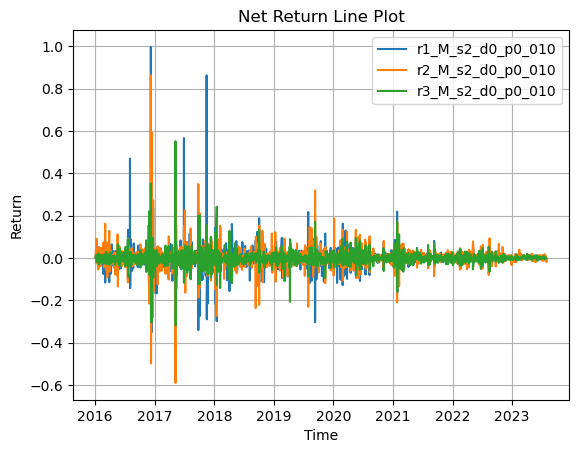

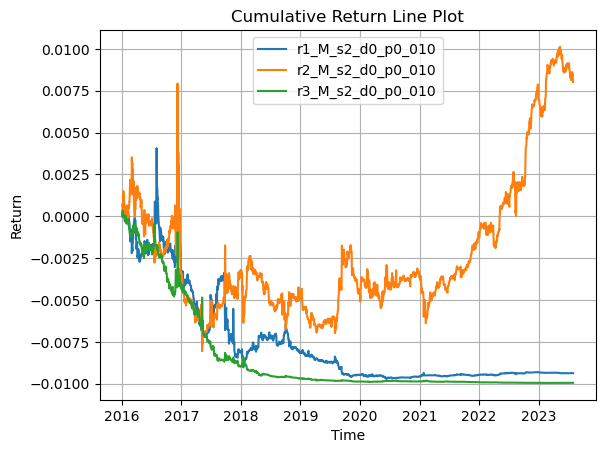

In [188]:
draw_ret_plt(df_m2)
draw_ret_plt(df_m2_s,ret =2)

#### 5.1.3 Difference in Ratio 

In this part, we do pairwise comparison between rank by themselves and by differences, keeping all othe parameters unchnged. 

* **Debt Market Cap Ratio**

For this one, changing the ranking method does not give a specefic improvement on return and volatility. The skew and kurtosis are changed. 

In [115]:
r1_M_s2_d0_p0_010 = quantile_trading_strategy(df_r1,df_price,LIBOR,0.1,'M',False,False,-1)
metrics_derived_from_return_series(r1_M_s2_d0_p0_010,ff_factors,'r1_M_s2_d1_p0_010')

mean  volatility  sharpe ratio (benchmark = 0)  \
r1_M_s2_d1_p0_010 -0.000049     0.05641                     -0.000877   

                   sharpe ratio (benchmark = rf)  \
r1_M_s2_d1_p0_010                      -0.089482   

                   sharpe ratio (benchmark = mkt)  sortino ratio       min  \
r1_M_s2_d1_p0_010                        -0.03768      -0.775034 -0.351793   

                        max  max drawdown  downside beta       VaR  \
r1_M_s2_d1_p0_010  0.997125     -0.982032      -0.002324 -0.057532   

                   CVaR (0.05)      Skew    Kurtosis  Calmar Ratio  \
r1_M_s2_d1_p0_010    -0.115978  5.861691  100.405074      0.005193   

                   final cumulative return  
r1_M_s2_d1_p0_010                -0.009375

In [116]:
r1_M_s2_d1_p0_010 = quantile_trading_strategy(df_r1,df_price,LIBOR,0.1,'M',False,True,-1)
metrics_derived_from_return_series(r1_M_s2_d1_p0_010,ff_factors,'r1_M_s2_d1_p0_010')

mean  volatility  sharpe ratio (benchmark = 0)  \
r1_M_s2_d1_p0_010 -0.000325    0.062908                     -0.005167   

                   sharpe ratio (benchmark = rf)  \
r1_M_s2_d1_p0_010                      -0.087849   

                   sharpe ratio (benchmark = mkt)  sortino ratio       min  \
r1_M_s2_d1_p0_010                       -0.039222      -0.789585 -0.396529   

                        max  max drawdown  downside beta       VaR  \
r1_M_s2_d1_p0_010  1.019453     -0.977968       0.001281 -0.058746   

                   CVaR (0.05)     Skew    Kurtosis  Calmar Ratio  \
r1_M_s2_d1_p0_010    -0.121299  6.78628  102.864559      0.005695   

                   final cumulative return  
r1_M_s2_d1_p0_010                -0.009741

In [117]:
m3 = list() 
m3_s = list() 
append_list(r1_M_s2_d1_p0_010,r1_trail,'r1_M_s2_d1_p0_010')
append_list(r1_M_s2_d0_p0_010,m3,'r1_M_s2_d0_p0_010',m=0)
append_list(r1_M_s2_d0_p0_010,m3_s,'r1_M_s2_d0_p0_010',m=1)
append_list(r1_M_s2_d1_p0_010,m3,'r1_M_s2_d1_p0_010',m=0)
append_list(r1_M_s2_d1_p0_010,m3_s,'r1_M_s2_d1_p0_010',m=1)

* **Return on Investment** 

Similar situation happend for this one. 

In [118]:
r2_M_s2_d0_p0_010 = quantile_trading_strategy(df_r2,df_price,LIBOR,0.1,'M',False,False,-1)
metrics_derived_from_return_series(r2_M_s2_d0_p0_010,ff_factors,'r2_M_s2_d0_p0_010')

mean  volatility  sharpe ratio (benchmark = 0)  \
r2_M_s2_d0_p0_010  0.001606    0.050818                      0.031605   

                   sharpe ratio (benchmark = rf)  \
r2_M_s2_d0_p0_010                      -0.066922   

                   sharpe ratio (benchmark = mkt)  sortino ratio       min  \
r2_M_s2_d0_p0_010                       -0.036044      -0.708918 -0.591043   

                       max  max drawdown  downside beta       VaR  \
r2_M_s2_d0_p0_010  0.86282     -0.891676      -0.001084 -0.052422   

                   CVaR (0.05)      Skew  Kurtosis  Calmar Ratio  \
r2_M_s2_d0_p0_010    -0.107926  2.343833  72.61133      0.003863   

                   final cumulative return  
r2_M_s2_d0_p0_010                 0.008015

In [119]:
r2_M_s1_d1_p0_010 = quantile_trading_strategy(df_r2,df_price,LIBOR,0.1,'M',False,True,1)
metrics_derived_from_return_series(r2_M_s1_d1_p0_010,ff_factors,'r2_M_s1_d1_p0_010')

mean  volatility  sharpe ratio (benchmark = 0)  \
r2_M_s1_d1_p0_010 -0.000776    0.051556                     -0.015056   

                   sharpe ratio (benchmark = rf)  \
r2_M_s1_d1_p0_010                       -0.11558   

                   sharpe ratio (benchmark = mkt)  sortino ratio       min  \
r2_M_s1_d1_p0_010                       -0.038918      -0.790941 -0.482801   

                        max  max drawdown  downside beta       VaR  \
r2_M_s1_d1_p0_010  0.965646     -0.983592      -0.001318 -0.060242   

                   CVaR (0.05)      Skew   Kurtosis  Calmar Ratio  \
r2_M_s1_d1_p0_010    -0.114142  4.382355  94.066816      0.006135   

                   final cumulative return  
r2_M_s1_d1_p0_010                -0.009754

In [120]:
r2_M_s2_d1_p0_010 = quantile_trading_strategy(df_r2,df_price,LIBOR,0.1,'M',False,True,-1)
metrics_derived_from_return_series(r2_M_s2_d1_p0_010,ff_factors,'r2_M_s2_d1_p0_010')

mean  volatility  sharpe ratio (benchmark = 0)  \
r2_M_s2_d1_p0_010  0.00051    0.051556                      0.009902   

                   sharpe ratio (benchmark = rf)  \
r2_M_s2_d1_p0_010                        -0.0913   

                   sharpe ratio (benchmark = mkt)  sortino ratio       min  \
r2_M_s2_d1_p0_010                       -0.037585      -0.668148 -0.965912   

                        max  max drawdown  downside beta      VaR  \
r2_M_s2_d1_p0_010  0.482535     -0.993737       0.001319 -0.04931   

                   CVaR (0.05)      Skew   Kurtosis  Calmar Ratio  \
r2_M_s2_d1_p0_010    -0.112927 -4.382364  94.066879      0.004778   

                   final cumulative return  
r2_M_s2_d1_p0_010                 -0.00974

In [121]:
append_list(r2_M_s2_d1_p0_010,r2_trail,'r2_M_s2_d1_p0_010')
append_list(r2_M_s2_d1_p0_010,m3,'r2_M_s2_d1_p0_010',m=0)
append_list(r2_M_s2_d1_p0_010,m3_s,'r2_M_s2_d1_p0_010',m=1)
append_list(r2_M_s1_d1_p0_010,m3,'r2_M_s1_d1_p0_010',m=0)
append_list(r2_M_s1_d1_p0_010,m3_s,'r2_M_s1_d1_p0_010',m=1)

* **Price to Earnings**

For this one, we can clearly tell that we should not use the difference between ratio as the ranking method. 

In [122]:
r3_M_s1_d1_p0_010 = quantile_trading_strategy(df_r3,df_price,LIBOR,0.1,'M',False,True,1)
metrics_derived_from_return_series(r3_M_s1_d1_p0_010,ff_factors,'r3_M_s1_d1_p0_010')

mean  volatility  sharpe ratio (benchmark = 0)  \
r3_M_s1_d1_p0_010 -0.000134    0.049398                     -0.002712   

                   sharpe ratio (benchmark = rf)  \
r3_M_s1_d1_p0_010                      -0.107828   

                   sharpe ratio (benchmark = mkt)  sortino ratio       min  \
r3_M_s1_d1_p0_010                       -0.039049       -0.80206 -0.497421   

                        max  max drawdown  downside beta       VaR  \
r3_M_s1_d1_p0_010  0.851314     -0.938526       -0.00036 -0.055822   

                   CVaR (0.05)      Skew   Kurtosis  Calmar Ratio  \
r3_M_s1_d1_p0_010    -0.110185  3.209687  78.537862      0.005731   

                   final cumulative return  
r3_M_s1_d1_p0_010                -0.009106

In [123]:
r3_M_s1_d0_p0_010 = quantile_trading_strategy(df_r3,df_price,LIBOR,0.1,'M',False,False,1)
metrics_derived_from_return_series(r3_M_s1_d0_p0_010,ff_factors,'r3_M_s1_d0_p0_010')

mean  volatility  sharpe ratio (benchmark = 0)  \
r3_M_s1_d0_p0_010  0.001955    0.033708                      0.058001   

                   sharpe ratio (benchmark = rf)  \
r3_M_s1_d0_p0_010                      -0.089769   

                   sharpe ratio (benchmark = mkt)  sortino ratio       min  \
r3_M_s1_d0_p0_010                       -0.035747      -0.997475 -0.551876   

                        max  max drawdown  downside beta       VaR  \
r3_M_s1_d0_p0_010  0.319149     -0.571677      -0.000246 -0.038149   

                   CVaR (0.05)      Skew   Kurtosis  Calmar Ratio  \
r3_M_s1_d0_p0_010    -0.081056 -2.791282  58.251297      0.005415   

                   final cumulative return  
r3_M_s1_d0_p0_010                 0.114203

* **Comparison**

In [124]:
append_list(r3_M_s1_d1_p0_010,r3_trail,'r3_M_s2_d1_p0_010')
append_list(r3_M_s1_d1_p0_010,m3,'r3_M_s1_d1_p0_010',m=0)
append_list(r3_M_s1_d1_p0_010,m3_s,'r3_M_s1_d1_p0_010',m=1)
append_list(r3_M_s1_d0_p0_010,m3,'r3_M_s1_d0_p0_010',m=0)
append_list(r3_M_s1_d0_p0_010,m3_s,'r3_M_s1_d0_p0_010',m=1)

In [125]:
df_m3_s =pd.concat(m3_s, axis =1)
df_m3 = pd.concat(m3, axis =1)
return_plot(df_m3)
return_plot(df_m3_s,ret=2)

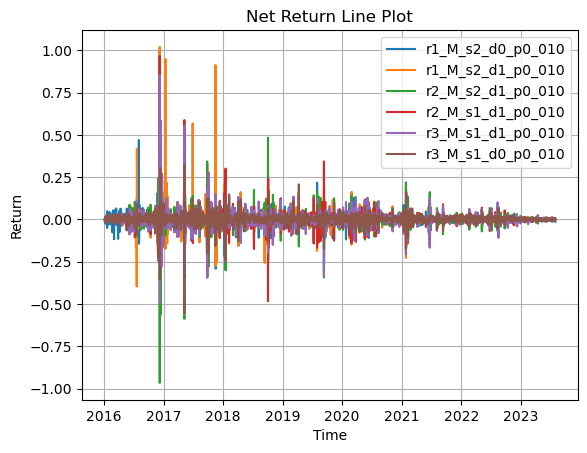

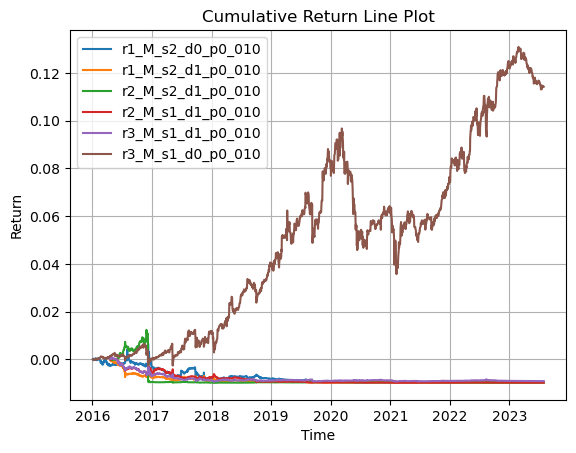

In [190]:
draw_ret_plt(df_m3)
draw_ret_plt(df_m3_s,ret =2)

#### 5.1.4 Time Period Change 

* **Debt Market Cap Ratio**

Time period change to weekly worsen the return.

In [127]:
r1_M_s1_d1_p0_010 = quantile_trading_strategy(df_r1,df_price,LIBOR,0.1,'M',False,True,1)
metrics_derived_from_return_series(r1_M_s1_d1_p0_010,ff_factors,'r1_M_s1_d1_p0_010')

mean  volatility  sharpe ratio (benchmark = 0)  \
r1_M_s1_d1_p0_010  0.000059    0.062908                      0.000943   

                   sharpe ratio (benchmark = rf)  \
r1_M_s1_d1_p0_010                      -0.081914   

                   sharpe ratio (benchmark = mkt)  sortino ratio       min  \
r1_M_s1_d1_p0_010                       -0.038802       -0.51197 -1.019719   

                        max  max drawdown  downside beta       VaR  \
r1_M_s1_d1_p0_010  0.396263     -1.020405      -0.001281 -0.051986   

                   CVaR (0.05)      Skew    Kurtosis  Calmar Ratio  \
r1_M_s1_d1_p0_010    -0.143207 -6.786287  102.864625      0.005081   

                   final cumulative return  
r1_M_s1_d1_p0_010                -0.010001

In [128]:
r1_W_s1_d1_p0_010 = quantile_trading_strategy(df_r1,df_price,LIBOR,0.1,'W',False,True,1)
metrics_derived_from_return_series(r1_W_s1_d1_p0_010,ff_factors,'r1_W_s1_d1_p0_010')

mean  volatility  sharpe ratio (benchmark = 0)  \
r1_W_s1_d1_p0_010 -0.001222    0.047531                       -0.0257   

                   sharpe ratio (benchmark = rf)  \
r1_W_s1_d1_p0_010                      -0.134432   

                   sharpe ratio (benchmark = mkt)  sortino ratio       min  \
r1_W_s1_d1_p0_010                       -0.040185        -0.7127 -1.293136   

                        max  max drawdown  downside beta       VaR  \
r1_W_s1_d1_p0_010  0.380653     -1.267306       0.001778 -0.050011   

                   CVaR (0.05)       Skew    Kurtosis  Calmar Ratio  \
r1_W_s1_d1_p0_010     -0.10835 -11.157968  304.758235      0.005102   

                   final cumulative return  
r1_W_s1_d1_p0_010                -0.010318

In [129]:
m4 = list() 
m4_s = list() 

In [130]:
append_list(r1_M_s1_d1_p0_010,r1_trail,'r1_M_s1_d1_p0_010')
append_list(r1_M_s1_d1_p0_010,m4,'r1_M_s1_d1_p0_010',m=0)
append_list(r1_M_s1_d1_p0_010,m4_s,'r1_M_s1_d1_p0_010',m=1)
append_list(r1_W_s1_d1_p0_010,r1_trail,'r1_W_s1_d1_p0_010')
append_list(r1_W_s1_d1_p0_010,m4,'r1_W_s1_d1_p0_010',m=0)
append_list(r1_W_s1_d1_p0_010,m4_s,'r1_W_s1_d1_p0_010',m=1)

* **Return on Investment** 

There is no siginificant impact for this one. 

In [191]:
r2_M_s2_d0_p0_010 = quantile_trading_strategy(df_r2,df_price,LIBOR,0.1,'M',False,False,strat=-1)
metrics_derived_from_return_series(r2_M_s2_d0_p0_010,ff_factors,'r2_M_s2_d0_p0_010')

mean  volatility  sharpe ratio (benchmark = 0)  \
r2_M_s2_d0_p0_010 -0.0005    0.034874                     -0.014328   

                   sharpe ratio (benchmark = rf)  \
r2_M_s2_d0_p0_010                      -0.156192   

                   sharpe ratio (benchmark = mkt)  sortino ratio       min  \
r2_M_s2_d0_p0_010                       -0.038187      -1.060787 -0.622427   

                        max  max drawdown  downside beta       VaR  \
r2_M_s2_d0_p0_010  0.465673     -0.968125      -0.000265 -0.026144   

                   CVaR (0.05)      Skew    Kurtosis  Calmar Ratio  \
r2_M_s2_d0_p0_010     -0.06927 -1.550197  123.595762      0.005733   

                   final cumulative return  
r2_M_s2_d0_p0_010                -0.008984

In [192]:
r2_W_s2_d0_p0_010 = quantile_trading_strategy(df_r2,df_price,LIBOR,0.1,'W',False,False,strat=-1)
metrics_derived_from_return_series(r2_W_s2_d0_p0_010,ff_factors,'r2_W_s2_d0_p0_010')

mean  volatility  sharpe ratio (benchmark = 0)  \
r2_W_s2_d0_p0_010 -0.000473    0.031314                     -0.015116   

                   sharpe ratio (benchmark = rf)  \
r2_W_s2_d0_p0_010                      -0.171805   

                   sharpe ratio (benchmark = mkt)  sortino ratio      min  \
r2_W_s2_d0_p0_010                       -0.038203      -1.187335 -0.49986   

                        max  max drawdown  downside beta       VaR  \
r2_W_s2_d0_p0_010  0.460466     -0.950932       0.000089 -0.021245   

                   CVaR (0.05)      Skew    Kurtosis  Calmar Ratio  \
r2_W_s2_d0_p0_010    -0.063212 -1.258928  115.362943      0.005809   

                   final cumulative return  
r2_W_s2_d0_p0_010                 -0.00855

In [134]:
append_list(r2_M_s2_d0_p0_010 ,r2_trail,'r2_M_s2_d0_p0_010')
append_list(r2_M_s2_d0_p0_010 ,m4,'r2_M_s2_d0_p0_010',m=0)
append_list(r2_M_s2_d0_p0_010 ,m4_s,'r2_M_s2_d0_p0_010',m=1)
append_list(r2_W_s2_d0_p0_010,r2_trail,'r2_W_s2_d0_p0_010')
append_list(r2_W_s2_d0_p0_010,m4,'r2_W_s2_d0_p0_010',m=0)
append_list(r2_W_s2_d0_p0_010,m4_s,'r2_W_s2_d0_p0_010',m=1)

* **Price to Earnings**

A slight improvement appear when we change the position adjustment period as weekly, but not large enough to draw extra attnetion. Also the skew and kurtosis greatly increase. The risk side/ downside beta looks better when we adjust weekly. 

In [194]:
r3_M_s1_d0_p0_010 = quantile_trading_strategy(df_r3,df_price,LIBOR,0.1,'M',False,False,1)
metrics_derived_from_return_series(r3_M_s1_d0_p0_010,ff_factors,'r3_M_s1_d0_p0_010')

mean  volatility  sharpe ratio (benchmark = 0)  \
r3_M_s1_d0_p0_010  0.001026    0.024925                      0.041157   

                   sharpe ratio (benchmark = rf)  \
r3_M_s1_d0_p0_010                      -0.155021   

                   sharpe ratio (benchmark = mkt)  sortino ratio      min  \
r3_M_s1_d0_p0_010                       -0.036732      -1.310539 -0.28219   

                        max  max drawdown  downside beta       VaR  \
r3_M_s1_d0_p0_010  0.429597     -0.501427       0.000626 -0.023896   

                   CVaR (0.05)      Skew   Kurtosis  Calmar Ratio  \
r3_M_s1_d0_p0_010     -0.05166  2.781936  74.300331      0.008027   

                   final cumulative return  
r3_M_s1_d0_p0_010                 0.029699

In [193]:
r3_W_s1_d0_p0_010 = quantile_trading_strategy(df_r3,df_price,LIBOR,0.1,'W',False,False,1)
metrics_derived_from_return_series(r3_W_s1_d0_p0_010,ff_factors,'r3_W_s1_d0_p0_010')

mean  volatility  sharpe ratio (benchmark = 0)  \
r3_W_s1_d0_p0_010  0.000939    0.020601                       0.04559   

                   sharpe ratio (benchmark = rf)  \
r3_W_s1_d0_p0_010                      -0.187925   

                   sharpe ratio (benchmark = mkt)  sortino ratio       min  \
r3_W_s1_d0_p0_010                       -0.036813      -1.578262 -0.272105   

                        max  max drawdown  downside beta       VaR  \
r3_W_s1_d0_p0_010  0.427823     -0.436397       0.000546 -0.018618   

                   CVaR (0.05)      Skew    Kurtosis  Calmar Ratio  \
r3_W_s1_d0_p0_010    -0.041551  4.095744  121.650528      0.009421   

                   final cumulative return  
r3_W_s1_d0_p0_010                 0.030534

In [137]:
append_list(r3_M_s1_d0_p0_010 ,r3_trail,'r3_M_s1_d0_p0_010')
append_list(r3_M_s1_d0_p0_010 ,m4,'r3_M_s1_d0_p0_010',m=0)
append_list(r3_M_s1_d0_p0_010 ,m4_s,'r3_M_s1_d0_p0_010',m=1)
append_list(r3_W_s1_d0_p0_010,r3_trail,'r3_W_s1_d0_p0_010')
append_list(r3_W_s1_d0_p0_010,m4,'r3_W_s1_d0_p0_010',m=0)
append_list(r3_W_s1_d0_p0_010,m4_s,'r3_W_s1_d0_p0_010',m=1)

* **Comparison**

In [138]:
df_m4_s =pd.concat(m4_s, axis =1)
df_m4 = pd.concat(m4, axis =1)
return_plot(df_m4)
return_plot(df_m4_s,ret=2)


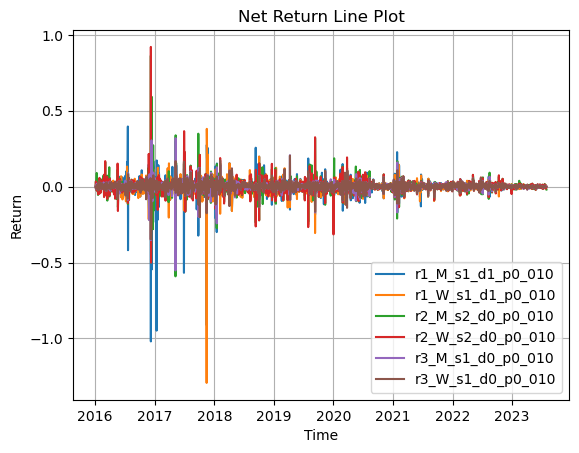

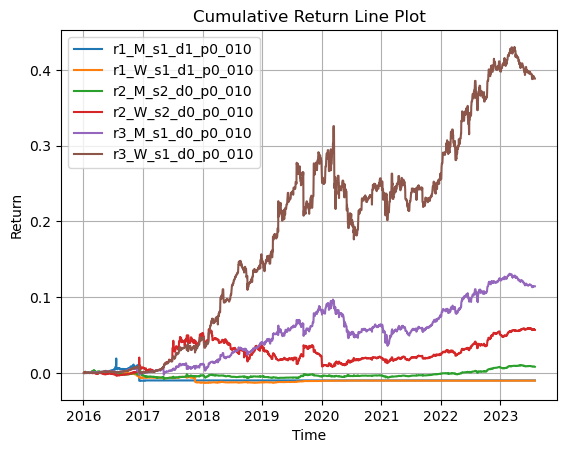

In [195]:
draw_ret_plt(df_m4)
draw_ret_plt(df_m4_s,ret =2)

#### 5.1.5 Percentile Change 

Here, we study the effect of the percentile upon our trading strategy. Since from analysis above, we can tell that the RTE ratio works best, we will use r3 to analyze. From the performance metric calculated down below, we can tell that percentile = 0.5 or 0.20 works best. percentile = 0.1 also behaves simialr as another two. However, for the percentile = 0.30, the result is not so good. Maybe limit the percentile in a range between [0.05, 0.20] is better. 

* **percentile  = 0.05**

In [140]:
r3_W_s1_d0_p0_005 = quantile_trading_strategy(df_r3,df_price,LIBOR,0.05,'W',False,False,1)
metrics_derived_from_return_series(r3_W_s1_d0_p0_005,ff_factors,'r3_W_s1_d0_p0_005')

mean  volatility  sharpe ratio (benchmark = 0)  \
r3_W_s1_d0_p0_005  0.002316    0.027854                      0.083147   

                   sharpe ratio (benchmark = rf)  \
r3_W_s1_d0_p0_005                      -0.094867   

                   sharpe ratio (benchmark = mkt)  sortino ratio       min  \
r3_W_s1_d0_p0_005                       -0.035348      -1.201672 -0.342438   

                       max  max drawdown  downside beta       VaR  \
r3_W_s1_d0_p0_005  0.22091     -0.502192      -0.001736 -0.034244   

                   CVaR (0.05)      Skew   Kurtosis  Calmar Ratio  \
r3_W_s1_d0_p0_005    -0.068648 -1.183412  22.742437      0.005445   

                   final cumulative return  
r3_W_s1_d0_p0_005                 0.374257

In [141]:
m5 = list() 
m5_s = list() 

In [142]:
append_list(r3_W_s1_d0_p0_005,m5,'r3_W_s1_d0_p0_005',m=0)
append_list(r3_W_s1_d0_p0_005,m5_s,'r3_W_s1_d0_p0_005',m=1)


* **percentile  = 0.10**

In [143]:
r3_W_s1_d0_p0_010 = quantile_trading_strategy(df_r3,df_price,LIBOR,0.1,'W',False,False,1)
metrics_derived_from_return_series(r3_W_s1_d0_p0_010,ff_factors,'r3_W_s1_d0_p0_010')

mean  volatility  sharpe ratio (benchmark = 0)  \
r3_W_s1_d0_p0_010  0.002306    0.026768                       0.08615   

                   sharpe ratio (benchmark = rf)  \
r3_W_s1_d0_p0_010                      -0.098865   

                   sharpe ratio (benchmark = mkt)  sortino ratio       min  \
r3_W_s1_d0_p0_010                       -0.035365      -1.253144 -0.346459   

                        max  max drawdown  downside beta       VaR  \
r3_W_s1_d0_p0_010  0.204263     -0.489812      -0.001143 -0.030544   

                   CVaR (0.05)      Skew   Kurtosis  Calmar Ratio  \
r3_W_s1_d0_p0_010    -0.066001 -1.413067  25.996246      0.005603   

                   final cumulative return  
r3_W_s1_d0_p0_010                 0.388569

In [144]:
append_list(r3_W_s1_d0_p0_010,m5,'r3_W_s1_d0_p0_010',m=0)
append_list(r3_W_s1_d0_p0_010,m5_s,'r3_W_s1_d0_p0_010',m=1)

* **percentile  = 0.20**

In [145]:
r3_W_s1_d0_p0_020 = quantile_trading_strategy(df_r3,df_price,LIBOR,0.2,'W',False,False,1)
metrics_derived_from_return_series(r3_W_s1_d0_p0_020,ff_factors,'r3_W_s1_d0_p0_020')

mean  volatility  sharpe ratio (benchmark = 0)  \
r3_W_s1_d0_p0_020  0.002267    0.025911                      0.087505   

                   sharpe ratio (benchmark = rf)  \
r3_W_s1_d0_p0_020                      -0.103431   

                   sharpe ratio (benchmark = mkt)  sortino ratio       min  \
r3_W_s1_d0_p0_020                       -0.035406      -1.298872 -0.347281   

                        max  max drawdown  downside beta       VaR  \
r3_W_s1_d0_p0_020  0.173304     -0.492265      -0.000909 -0.028932   

                   CVaR (0.05)      Skew   Kurtosis  Calmar Ratio  \
r3_W_s1_d0_p0_020    -0.063864 -1.674315  28.242018      0.005654   

                   final cumulative return  
r3_W_s1_d0_p0_020                 0.376094

In [146]:
append_list(r3_W_s1_d0_p0_020,m5,'r3_W_s1_d0_p0_020',m=0)
append_list(r3_W_s1_d0_p0_020,m5_s,'r3_W_s1_d0_p0_020',m=1)

* **percentile  = 0.30**

In [147]:
r3_W_s1_d0_p0_030 = quantile_trading_strategy(df_r3,df_price,LIBOR,0.3,'W',False,False,1)
metrics_derived_from_return_series(r3_W_s1_d0_p0_030,ff_factors,'r3_W_s1_d0_p0_030')

mean  volatility  sharpe ratio (benchmark = 0)  \
r3_W_s1_d0_p0_030  0.002218    0.025456                      0.087148   

                   sharpe ratio (benchmark = rf)  \
r3_W_s1_d0_p0_030                      -0.106977   

                   sharpe ratio (benchmark = mkt)  sortino ratio       min  \
r3_W_s1_d0_p0_030                       -0.035458      -1.325266 -0.349165   

                        max  max drawdown  downside beta      VaR  \
r3_W_s1_d0_p0_030  0.173176     -0.493374      -0.000648 -0.02917   

                   CVaR (0.05)      Skew   Kurtosis  Calmar Ratio  \
r3_W_s1_d0_p0_030    -0.062593 -1.826482  30.284024       0.00574   

                   final cumulative return  
r3_W_s1_d0_p0_030                 0.349448

In [148]:
append_list(r3_W_s1_d0_p0_030,m5,'r3_W_s1_d0_p0_030',m=0)
append_list(r3_W_s1_d0_p0_030,m5_s,'r3_W_s1_d0_p0_030',m=1)

* **Comparison**

Those straties seem to follow a similar trend. 

In [149]:
df_m5_s =pd.concat(m5_s, axis =1)
df_m5 = pd.concat(m5, axis =1)
return_plot(df_m5)
return_plot(df_m5_s,ret=2)


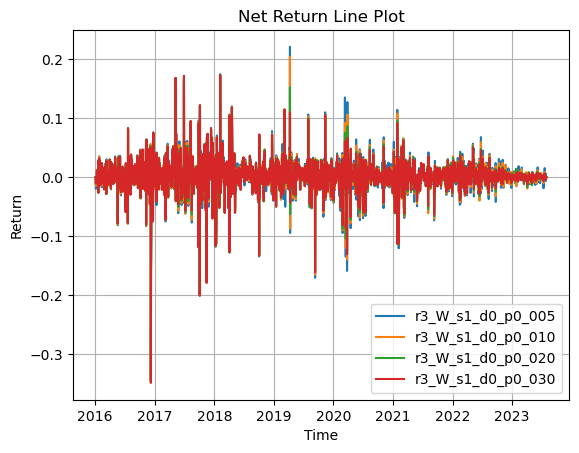

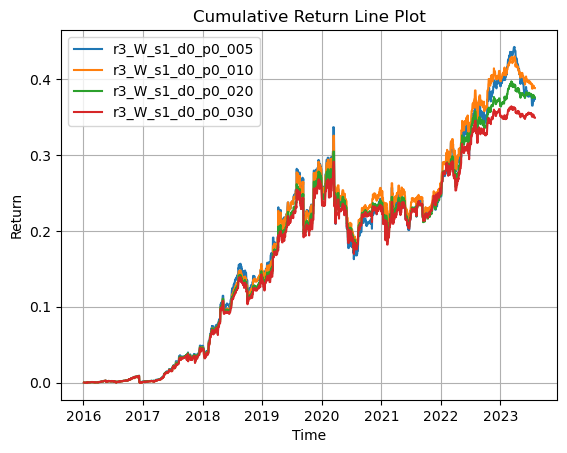

In [196]:
draw_ret_plt(df_m5)
draw_ret_plt(df_m5_s,ret =2)

#### 5.1.6 Position Size Change 

Here, we only try doubling the most 'attractive' vigintiles. Except for PTE, other ratios get slight improvment. 

* **Debt Market Cap Ratio**

In [151]:
r1_M_s1_d0_p0_010 = quantile_trading_strategy(df_r1,df_price,LIBOR,0.1,'M',False,False,1)
metrics_derived_from_return_series(r1_M_s1_d0_p0_010,ff_factors,'r1_M_s1_d0_p0_010')

mean  volatility  sharpe ratio (benchmark = 0)  \
r1_M_s1_d0_p0_010 -0.000216     0.05641                     -0.003834   

                   sharpe ratio (benchmark = rf)  \
r1_M_s1_d0_p0_010                       -0.09265   

                   sharpe ratio (benchmark = mkt)  sortino ratio       min  \
r1_M_s1_d0_p0_010                       -0.037945      -0.588869 -0.997391   

                        max  max drawdown  downside beta       VaR  \
r1_M_s1_d0_p0_010  0.351527      -0.99993       0.002323 -0.050039   

                   CVaR (0.05)      Skew   Kurtosis  Calmar Ratio  \
r1_M_s1_d0_p0_010    -0.124933 -5.861698  100.40513      0.005267   

                   final cumulative return  
r1_M_s1_d0_p0_010                -0.009999

In [152]:
r1_M_s1_d0_p1_010 = quantile_trading_strategy_1(df_r1,df_price,LIBOR,0.1,'M',False,False,1)
metrics_derived_from_return_series(r1_M_s1_d0_p1_010,ff_factors,'r1_M_s1_d0_p1_010')

mean  volatility  sharpe ratio (benchmark = 0)  \
r1_M_s1_d0_p1_010 -0.000016    0.057298                     -0.000272   

                   sharpe ratio (benchmark = rf)  \
r1_M_s1_d0_p1_010                      -0.087531   

                   sharpe ratio (benchmark = mkt)  sortino ratio       min  \
r1_M_s1_d0_p1_010                       -0.037636      -0.764498 -0.344277   

                        max  max drawdown  downside beta       VaR  \
r1_M_s1_d0_p1_010  1.009354     -0.983351      -0.002592 -0.058676   

                   CVaR (0.05)      Skew    Kurtosis  Calmar Ratio  \
r1_M_s1_d0_p1_010     -0.11793  5.873453  100.512075      0.005152   

                   final cumulative return  
r1_M_s1_d0_p1_010                -0.009384

* **Return on Investment** 

In [153]:
r2_M_s1_d0_p0_010 = quantile_trading_strategy(df_r2,df_price,LIBOR,0.1,'M',False,False,1)
metrics_derived_from_return_series(r2_M_s1_d0_p0_010,ff_factors,'r2_M_s1_d0_p0_010')

mean  volatility  sharpe ratio (benchmark = 0)  \
r2_M_s1_d0_p0_010 -0.001872    0.050818                     -0.036834   

                   sharpe ratio (benchmark = rf)  \
r2_M_s1_d0_p0_010                      -0.134999   

                   sharpe ratio (benchmark = mkt)  sortino ratio       min  \
r2_M_s1_d0_p0_010                       -0.039607      -0.739991 -0.863086   

                        max  max drawdown  downside beta       VaR  \
r2_M_s1_d0_p0_010  0.590777     -0.999132       0.001084 -0.056486   

                   CVaR (0.05)      Skew   Kurtosis  Calmar Ratio  \
r2_M_s1_d0_p0_010    -0.118541 -2.343841  72.611328      0.006928   

                   final cumulative return  
r2_M_s1_d0_p0_010                 -0.00999

In [154]:
r2_M_s1_d0_p1_010 = quantile_trading_strategy_1(df_r2,df_price,LIBOR,0.1,'M',False,False,1)
metrics_derived_from_return_series(r2_M_s1_d0_p1_010,ff_factors,'r2_M_s1_d0_p1_010')

mean  volatility  sharpe ratio (benchmark = 0)  \
r2_M_s1_d0_p1_010  0.001769    0.052043                      0.033988   

                   sharpe ratio (benchmark = rf)  \
r2_M_s1_d0_p1_010                      -0.062289   

                   sharpe ratio (benchmark = mkt)  sortino ratio       min  \
r2_M_s1_d0_p1_010                       -0.035876      -0.684262 -0.592161   

                       max  max drawdown  downside beta     VaR  CVaR (0.05)  \
r2_M_s1_d0_p1_010  0.86303     -0.892306      -0.001189 -0.0551    -0.111898   

                       Skew  Kurtosis  Calmar Ratio  final cumulative return  
r2_M_s1_d0_p1_010  2.129343   66.7024      0.003678                 0.011609

* **Price to Earnings**

In [155]:
r3_M_s1_d0_p0_010 = quantile_trading_strategy(df_r3,df_price,LIBOR,0.1,'M',False,False,1)
metrics_derived_from_return_series(r3_M_s1_d0_p0_010,ff_factors,'r3_M_s1_d0_p0_010')

mean  volatility  sharpe ratio (benchmark = 0)  \
r3_M_s1_d0_p0_010  0.001955    0.033708                      0.058001   

                   sharpe ratio (benchmark = rf)  \
r3_M_s1_d0_p0_010                      -0.089769   

                   sharpe ratio (benchmark = mkt)  sortino ratio       min  \
r3_M_s1_d0_p0_010                       -0.035747      -0.997475 -0.551876   

                        max  max drawdown  downside beta       VaR  \
r3_M_s1_d0_p0_010  0.319149     -0.571677      -0.000246 -0.038149   

                   CVaR (0.05)      Skew   Kurtosis  Calmar Ratio  \
r3_M_s1_d0_p0_010    -0.081056 -2.791282  58.251297      0.005415   

                   final cumulative return  
r3_M_s1_d0_p0_010                 0.114203

In [156]:
r3_M_s1_d0_p1_010 = quantile_trading_strategy_1(df_r3,df_price,LIBOR,0.1,'M',False,False,1)
metrics_derived_from_return_series(r3_M_s1_d0_p1_010,ff_factors,'r3_M_s1_d0_p1_010')

mean  volatility  sharpe ratio (benchmark = 0)  \
r3_M_s1_d0_p1_010 -0.002219    0.034065                      -0.06515   

                   sharpe ratio (benchmark = rf)  \
r3_M_s1_d0_p1_010                      -0.209313   

                   sharpe ratio (benchmark = mkt)  sortino ratio       min  \
r3_M_s1_d0_p1_010                       -0.039955      -1.279168 -0.318306   

                        max  max drawdown  downside beta       VaR  \
r3_M_s1_d0_p1_010  0.550271     -0.995679       0.000262 -0.039698   

                   CVaR (0.05)     Skew   Kurtosis  Calmar Ratio  \
r3_M_s1_d0_p1_010    -0.071945  2.68803  55.531706      0.007302   

                   final cumulative return  
r3_M_s1_d0_p1_010                 -0.00995

### 5.2 Combination of three ratios 

In this section, we wil try to check the combinatio of three ratios and their impacts, if we adjust their weight. I normalize all the ratios in order to make them able to join together. 

Among all, the equally weighted one perform the best, and the heavy-weighted ROI one works the worst. 

In [157]:
df1_normalized, df2_normalized, df3_normalized = normalize_dataframes(df_r1, df_r2, df_r3)

* **$w_1 = 0, w_2 = 0.2,w_3 = 0.8$**

In [158]:
a, b, c = 0,0.2,0.8 
df1_normalized_1 = a * df1_normalized
df2_normalized_1 = b * df2_normalized
df3_normalized_1 = c * df3_normalized
df_combine_1 = df1_normalized_1 + df2_normalized_1 + df3_normalized_1

In [159]:
t1 = quantile_trading_strategy(df_combine_1,df_price,LIBOR,0.1,'M',False,False,1)
metrics_derived_from_return_series(t1,ff_factors,'t1')

mean  volatility  sharpe ratio (benchmark = 0)  \
t1  0.000425    0.028477                      0.014913   

    sharpe ratio (benchmark = rf)  sharpe ratio (benchmark = mkt)  \
t1                      -0.157339                       -0.037315   

    sortino ratio       min       max  max drawdown  downside beta       VaR  \
t1      -1.408891 -0.283831  0.509062     -0.780558       0.000655 -0.024536   

    CVaR (0.05)     Skew    Kurtosis  Calmar Ratio  final cumulative return  
t1    -0.054899  4.99698  108.213514      0.005926                 0.000864

In [160]:
mt = list() 
mt_s = list() 

In [161]:
append_list(t1,mt,'t1',m=0)
append_list(t1,mt_s,'t1',m=1)

* **$w_1 = 1/3, w_2 = 1/3,w_3 = 1/3$**

In [162]:
a, b, c = 1/3,1/3,1/3
df1_normalized_2 = a * df1_normalized
df2_normalized_2 = b * df2_normalized
df3_normalized_2 = c * df3_normalized
df_combine_2 = df1_normalized_2 + df2_normalized_2 + df3_normalized_2

In [163]:
t2 = quantile_trading_strategy(df_combine_2,df_price,LIBOR,0.1,'M',False,False,1)
metrics_derived_from_return_series(t2,ff_factors,'t2')

mean  volatility  sharpe ratio (benchmark = 0)  \
t2  0.00138    0.023498                      0.058741   

    sharpe ratio (benchmark = rf)  sharpe ratio (benchmark = mkt)  \
t2                      -0.149215                       -0.036344   

    sortino ratio       min       max  max drawdown  downside beta       VaR  \
t2      -1.369176 -0.278914  0.418178     -0.395066      -0.000618 -0.022836   

    CVaR (0.05)      Skew   Kurtosis  Calmar Ratio  final cumulative return  
t2    -0.047599  2.726527  82.084988       0.00929                 0.073002

In [164]:
append_list(t2,mt,'t2',m=0)
append_list(t2,mt_s,'t2',m=1)

* **$w_1 = 0.1, w_2 = 0.2,w_3 = 0.7$**

In [165]:
a, b, c = 0.1,0.2,0.7
df1_normalized_3 = a * df1_normalized
df2_normalized_3 = b * df2_normalized
df3_normalized_3 = c * df3_normalized
df_combine_3 = df1_normalized_3 + df2_normalized_3 + df3_normalized_3

In [166]:
t3 = quantile_trading_strategy(df_combine_3,df_price,LIBOR,0.1,'M',False,False,1)
metrics_derived_from_return_series(t3,ff_factors,'t3')

mean  volatility  sharpe ratio (benchmark = 0)  \
t3  0.000455    0.021825                      0.020835   

    sharpe ratio (benchmark = rf)  sharpe ratio (benchmark = mkt)  \
t3                      -0.200337                       -0.037295   

    sortino ratio       min       max  max drawdown  downside beta       VaR  \
t3       -1.50714 -0.284818  0.422999     -0.642697        0.00068 -0.020696   

    CVaR (0.05)      Skew    Kurtosis  Calmar Ratio  final cumulative return  
t3    -0.044668  3.535585  114.192895      0.007151                 0.005306

In [167]:
append_list(t3,mt,'t3',m=0)
append_list(t3,mt_s,'t3',m=1)

* **$w_1 = 0.2, w_2 = 0.7,w_3 = 0.1$**

In [168]:
a, b, c = 0.2,0.7,0.1
df1_normalized_4 = a * df1_normalized
df2_normalized_4 = b * df2_normalized
df3_normalized_4 = c * df3_normalized
df_combine_4 = df1_normalized_4 + df2_normalized_4 + df3_normalized_4

In [169]:
t4 = quantile_trading_strategy(df_combine_4,df_price,LIBOR,0.1,'M',False,False,1)
metrics_derived_from_return_series(t4,ff_factors,'t4')

mean  volatility  sharpe ratio (benchmark = 0)  \
t4  0.000441    0.035846                      0.012302   

    sharpe ratio (benchmark = rf)  sharpe ratio (benchmark = mkt)  \
t4                      -0.125866                       -0.037295   

    sortino ratio      min       max  max drawdown  downside beta       VaR  \
t4      -1.212397 -0.46364  0.610741     -0.799854        0.00002 -0.025007   

    CVaR (0.05)      Skew    Kurtosis  Calmar Ratio  final cumulative return  
t4    -0.074996  1.309288  105.933524      0.005763                -0.003496

In [170]:
append_list(t4,mt,'t4',m=0)
append_list(t4,mt_s,'t4',m=1)

* **$w_1 = 0.7, w_2 = 0.1,w_3 = 0.2$**

In [171]:
a, b, c = 0.7,0.1,0.2
df1_normalized_5 = a * df1_normalized
df2_normalized_5 = b * df2_normalized
df3_normalized_5 = c * df3_normalized
df_combine_5 = df1_normalized_5 + df2_normalized_5 + df3_normalized_5

In [172]:
t5 = quantile_trading_strategy(df_combine_5,df_price,LIBOR,0.1,'M',False,False,1)
metrics_derived_from_return_series(t5,ff_factors,'t5')

mean  volatility  sharpe ratio (benchmark = 0)  \
t5  0.000427    0.020093                      0.021243   

    sharpe ratio (benchmark = rf)  sharpe ratio (benchmark = mkt)  \
t5                      -0.217729                       -0.037284   

    sortino ratio       min      max  max drawdown  downside beta       VaR  \
t5      -1.791521 -0.218243  0.15204     -0.531624      -0.001395 -0.023541   

    CVaR (0.05)      Skew   Kurtosis  Calmar Ratio  final cumulative return  
t5    -0.048502 -0.875981  24.615623      0.008697                 0.005255

In [173]:
append_list(t5,mt,'t5',m=0)
append_list(t5,mt_s,'t5',m=1)

* **Comparison**

In [174]:
df_mt_s =pd.concat(mt_s, axis =1)
df_mt = pd.concat(mt, axis =1)
return_plot(df_mt)
return_plot(df_mt_s,ret=2)

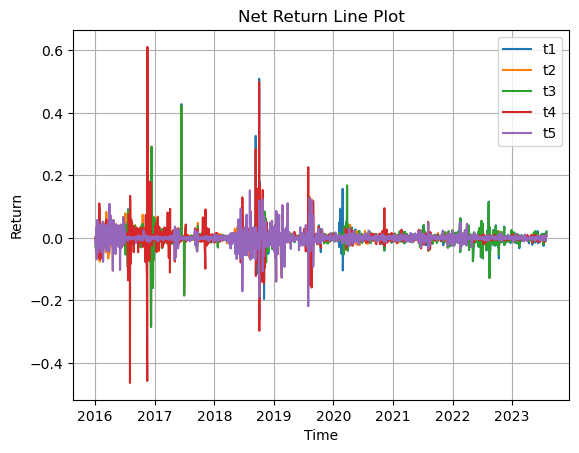

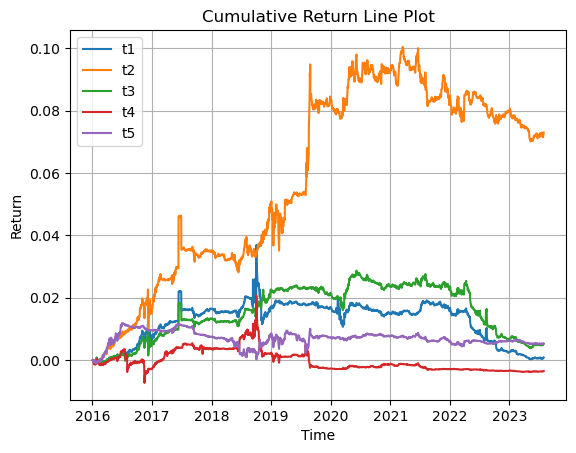

In [197]:
draw_ret_plt(df_mt)
draw_ret_plt(df_mt_s,ret =2)

## 6.Analysis 

### 6.1 Descriptive Statistics 

From the study above, it seems like the PTE ratio works best for selected tickers. However, the combination of them (equally weighted) also works good. Some concern may be arised about the way of implementing the trading strategy. Also, from the metrics result above, a common pattern is that the negtive sharpe ratio when benchmark is market factor and risk free rate. Also, the kurtosis often have a very large value. Though the var and cvar are not large, we may need to pay attention to outlier situation. Maybe we can try to exclude the extreme value or prices when we are selectly the tickers. 

In [176]:
metrics_derived_from_return_series(t2,ff_factors,'t2')

mean  volatility  sharpe ratio (benchmark = 0)  \
t2  0.00138    0.023498                      0.058741   

    sharpe ratio (benchmark = rf)  sharpe ratio (benchmark = mkt)  \
t2                      -0.149215                       -0.036344   

    sortino ratio       min       max  max drawdown  downside beta       VaR  \
t2      -1.369176 -0.278914  0.418178     -0.395066      -0.000618 -0.022836   

    CVaR (0.05)      Skew   Kurtosis  Calmar Ratio  final cumulative return  
t2    -0.047599  2.726527  82.084988       0.00929                 0.073002

In [177]:
metrics_derived_from_return_series(r3_W_s1_d0_p0_020,ff_factors,'r3_W_s1_d0_p0_020')

mean  volatility  sharpe ratio (benchmark = 0)  \
r3_W_s1_d0_p0_020  0.002267    0.025911                      0.087505   

                   sharpe ratio (benchmark = rf)  \
r3_W_s1_d0_p0_020                      -0.103431   

                   sharpe ratio (benchmark = mkt)  sortino ratio       min  \
r3_W_s1_d0_p0_020                       -0.035406      -1.298872 -0.347281   

                        max  max drawdown  downside beta       VaR  \
r3_W_s1_d0_p0_020  0.173304     -0.492265      -0.000909 -0.028932   

                   CVaR (0.05)      Skew   Kurtosis  Calmar Ratio  \
r3_W_s1_d0_p0_020    -0.063864 -1.674315  28.242018      0.005654   

                   final cumulative return  
r3_W_s1_d0_p0_020                 0.376094

In [178]:
metrics_derived_from_return_series(r3_M_s1_d0_p0_010,ff_factors,'r3_M_s1_d0_p0_010')

mean  volatility  sharpe ratio (benchmark = 0)  \
r3_M_s1_d0_p0_010  0.001955    0.033708                      0.058001   

                   sharpe ratio (benchmark = rf)  \
r3_M_s1_d0_p0_010                      -0.089769   

                   sharpe ratio (benchmark = mkt)  sortino ratio       min  \
r3_M_s1_d0_p0_010                       -0.035747      -0.997475 -0.551876   

                        max  max drawdown  downside beta       VaR  \
r3_M_s1_d0_p0_010  0.319149     -0.571677      -0.000246 -0.038149   

                   CVaR (0.05)      Skew   Kurtosis  Calmar Ratio  \
r3_M_s1_d0_p0_010    -0.081056 -2.791282  58.251297      0.005415   

                   final cumulative return  
r3_M_s1_d0_p0_010                 0.114203

### 6.2 Fama French Factors Check 

From the correlation matrix check, the net return seems to have a positive correltaion with three factors, and negative corrleation with risk free rate. 

The intercept (const) is 0.0014, which suggests a small positive return not explained by the market factors.

The Mkt-RF coefficient is 0.0001, indicating a negligible impact from market excess returns on the return on capital.

The SMB coefficient is 0.0005, suggesting a slightly positive effect from the size premium.

The HML coefficient is 0.0002, also indicating a slightly positive effect from the value premium.

In [179]:
ff_factors = ff_factors[start:end]

In [180]:
df_temp1 = ff_factors.copy()
df_temp1['return on capital'] = t2['net_return']
df_temp1.dropna(inplace = True)

In [181]:
df_reset = df_temp1.reset_index()
df_melted = df_reset.melt(id_vars=df_reset.columns[0], var_name='Variable', value_name='Return')
fig = px.line(df_melted, x=df_reset.columns[0], y='Return', color='Variable', title='Line Chart for Multiple Returns')
fig.update_layout(
        template="none",
        autosize = True,
        showlegend=True 
    )
fig.show()

In [182]:
df_temp1.corr()

Mkt-RF       SMB       HML        RF  return on capital
Mkt-RF             1.000000 -0.362135 -0.084218 -0.025317           0.001337
SMB               -0.362135  1.000000  0.011112 -0.030842           0.007690
HML               -0.084218  0.011112  1.000000 -0.041736           0.004585
RF                -0.025317 -0.030842 -0.041736  1.000000          -0.020595
return on capital  0.001337  0.007690  0.004585 -0.020595           1.000000

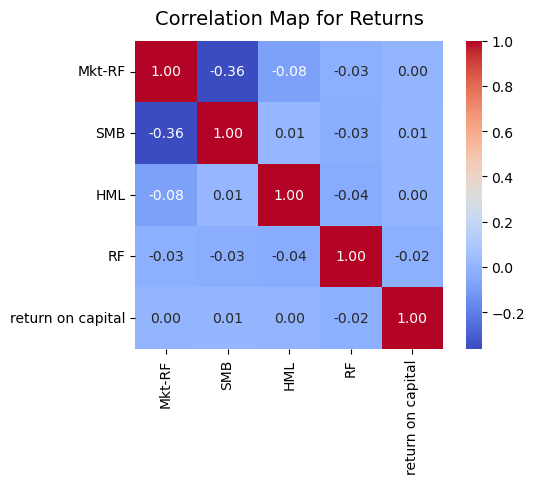

In [183]:
plt.figure(figsize=(6, 4))
ax = sns.heatmap(df_temp1.corr(), annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True) 
ax.set_title('Correlation Map for Returns', fontdict={'fontsize': 14}, pad=12)
plt.show()

In [184]:
X = sm.add_constant(df_temp1.loc[:,['Mkt-RF','SMB','HML']])
Y = df_temp1['return on capital']
model = sm.OLS(Y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      return on capital   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                   0.06510
Date:                Thu, 01 Feb 2024   Prob (F-statistic):              0.978
Time:                        20:25:41   Log-Likelihood:                 4445.2
No. Observations:                1906   AIC:                            -8882.
Df Residuals:                    1902   BIC:                            -8860.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.001      2.567      0.0

## 7.Conclusion 

In this notebook, I implement the quantile trading strategy and use three ratios to create trading signals. I spend some portion discussing the effect of changing the parameters. 

Some parts I need to improve:

1. For the data part, I decide to use a rather strict way of selection, resulting only 243 tickers left. Therefore, the universe for implementing the traing strategy is roughly small. If I have time, I may try to use filtered tickers using another method to filter. Since I did not do pairwise comparison, I do not know the impact of the universe size at this point.
2. For the data selection part again, I think I need to do more descriptive statistics study that allow me to know the tickers selected better. Maybe there are extremely pricy tickers that lead the trading strategy more volatile. This part needs to further investigate. 
3. For the trading strategy implementation part, I close my position/ adjust my position only at the end of month. Unlike previous strategy, I did not implement any protection toward extreme loss. From the return graph, I think there are some extreme return resulting in certain period. 
4. For the coding part, this notebook needs to be more concise, and the notation is not clear enough. If I have time, I will try to improve the notation and clarification in section 5. 
5. For the analysis part, I did not conduct enough changes on parameters to tell a clearer clue about which one works best. Now the optimal one is the combination of three. The PTE works particularly well, which draw my attention and decide to give it a larger weight. However, the combination result does not match my expectation. I think I need to dig deeper about the characteristcis about those three ratios. 
6. For the plot part, if I can show the ticker ratio change or anything more specefic,the illustration may be better. 
7. I think I should conduct a more in-depth analysis regarding the optimal one, but only used ff-factors to discuss them. 

Besides the parts I want to improve, all the detailed analysis and conclusion for each section are at the top of each section above. 

## 8.Reference 

Data: 
Code Selection: https://www.sec.gov/corpfin/division-of-corporation-finance-standard-industrial-classification-sic-code-list 

ZFB Documentation: https://data.nasdaq.com/databases/ZFB#anchor-coverage

LIBOR: 
https://www.bankrate.com/rates/interest-rates/3-month-libor/#:~:text=3%20Month%20LIBOR%20Rate,-LIBOR%2C%20other%20interest&text=It's%20the%20rate%20of%20interest,changes%20in%20the%20prime%20rate.